# EDA
- 기초적인 데이터셋의 정보를 확인한다

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf", # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

from geopy.geocoders import Nominatim

## 데이터 로드

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/root/data/train.csv'
test_path  = '/root/data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [4]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

시군구     번지     본번   부번    아파트명  전용면적(㎡)    계약년월  계약일  층  건축년도  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  201712    8  3  1987   

   ...    건축면적   주차대수 기타/의무/임대/임의=1/2/3/4                  단지승인일 사용허가여부  \
0  ...  4858.0  262.0                  임의  2022-11-17 13:00:29.0      Y   

  관리비 업로드        좌표X        좌표Y                  단지신청일  target  
0       N  127.05721  37.476763  2022-11-17 10:19:06.0  124000  

[1 rows x 52 columns]

시군구     번지     본번   부번    아파트명  전용면적(㎡)    계약년월  계약일  층  건축년도  \
0  서울특별시 강남구 개포동  658-1  658.0  1.0  개포6차우성    79.97  202307   26  5  1987   

   ... 청소비관리형태    건축면적   주차대수 기타/의무/임대/임의=1/2/3/4                  단지승인일  \
0  ...      직영  4858.0  262.0                  임의  2022-11-17 13:00:29.0   

  사용허가여부 관리비 업로드        좌표X        좌표Y                  단지신청일  
0      Y       N  127.05721  37.476763  2022-11-17 10:19:06.0  

[1 rows x 51 columns]

## 컬럼

- `시군구` : 해당 집의 주소, 시군구
- `번지` : 집의 번지수, 상세주소
- `본번` : 번지의 앞부분
- `부번` : 번지의 뒷부분
- `아파트명` : 해당 집의 건물(아파트) 이름
- `전용면적` : 집의 내부에서 실제로 사람이 사용하는 면적
- `계약년월` : 집의 거래가 이루어진 년, 월
- `계약일` : 집의 거래가 이루어진 일
- `층` : 아파트에서 집이 위치한 층
- `건축년도` : 아파트 건물이 지어진 년도
- `도로명` : 아파트가 위치한 도로명(도로명 주소)
- `해제사유발생일` : 지방자치단체에 주택 매매를 신고한 후 계약이 취소된 날자 (주택거래 기록만 남겨서 집값을 올리는 것을 막는 용도로 보임)
                    해당 컬럼에 값이 존재하면 거래하려다 취소된 케이스, 즉 부당거래로 집 값을 올리려거나 단순 변심으로 계약을 파기한 경우
                    -> 이 경우 해당 데이터를 삭제해야하나?, dt_test에도 해당 컬럼에 값이 존재하는 케이스가 상당함 212개 존재
- `등기신청일자` : 등기 이전 신청일자
- `거래유형` : 부동산 중개 여부
- `중개사소재지` : 부동산 중개사의 소재지
- `k-단지분류(아파트,주상복합등등)` : 건물분류, 아파트, 주상복합, 도시형 생활주택(주상복합), 도시형 생활주택(아파트), 연립주택              
- `k-전화번호` : 전화번호
- `k-팩스번호` : 팩스번호
- `단지소개기존clob` : 먼지 모르겠음
- `k-세대타입(분양형태)` : 집의 구매 유형 / 분양, 임대, 기타(매매?)
- `k-관리방식` : 아파트 관리방식 / 위탁관리, 자치관리, 직영
- `k-복도유형` : 아파트유형 / 계단식, 혼합식, 복도식, 타워형, 기타
- `k-난방방식` : 난방방식
- `k-전체동수` : 단지의 동수
- `k-전체세대수` : 단지 천체의 세대수
- `k-건설사(시공사)` : 실제로 건물을 짓는 회사
- `k-시행사` : 부동산 개발사업의 실질적인 사업 운영자로 사업의 기획 단계부터 전 과정을 총체적으로 진행하고 관리하는 회사
- `k-사용검사일-사용승인일` : 건축 시공 허가일과 건축한 건물의 사용을 허가받은 날
- `k-연면적` : 대지에 들어선 하나의 건축물의 바닥면적의 합계, 지상층은 물론 지하층, 주차장시설 등을 모두 포함
- `k-주거전용면적` :<br>
                    1. 주거용으로만 쓰이는 건축물의 면적<br>
                    2. 단독주택의 경우에는 건축물의 전체면적에서 지하실, 본 건물과 분리된 창고, 차고 및 변소의 면적을 제외<br>
                    3. 공동주택의 경우에는 건축물의 바닥면적에서 복도, 계단, 옥탑, 전기 및 기계실, 보일러실, 지하실, 관리사무실 및 경비실 등 2세대 이상이 공동으로 사용하거나 주거의 용도에 직접 쓰이지 않는 공용부문의 면적을 제외한 면적<br>
                    4. 2009년 4월 1일 이후로 공동주택의 공급면적을 세대별로 표시하는 경우 ‘주거전용면적’으로 표시
- `k-관리비부과면적` : 관리비를 배분하는 기준면적
- `k-전용면적별세대현황(60㎡이하)` : ???, 전용면적을 60으로 잡을때 아파트 단지에 최대 몇세대가 사는지?(예상)
- `k-전용면적별세대현황(60㎡~85㎡이하)` : ???, 전용면적을 60~85으로 잡을때 아파트 단지에 최대 몇세대가 사는지?(예상)
- `k-85㎡~135㎡이하` : ???, 전용면적을 85~135으로 잡을때 아파트 단지에 최대 몇세대가 사는지?(예상), 25~30평
- `k-135㎡초과` : ???, 전용면적을 135으로 잡을때 아파트 단지에 최대 몇세대가 사는지?(예상), 40평 초과
- `k-홈페이지` : 홈페이지 주소
- `k-등록일자` : ???
- `k-수정일자` : ???
- `고용보험관리번호` : 어떤고용?, 경비원분들?
- `경비비관리형태` : 위탁, 직영, 위탁+직영, 기타
- `세대전기계약방법` : 종합계약, 단일게약
- `청소비관리형태` : 위탁, 직영, 위탁+직영, 기타
- `건축면적` : 건축물의 외벽의 중심선으로 둘러싸인 부분의 수평투영면적
- `주차대수` : 주차가능 대수
- `기타/의무/임대/임의=1/2/3/4` : 집의 판매유형
- `단지승인일` : 사람 살기 시작해도 되는 날 입주일
- `사용허가여부` : ???
- `관리비 업로드` : 관리비 알려주는지?
- `좌표X` : 위도
- `좌표Y` : 경도
- `단지신청일` : 사용승인 신청한날
- `target` : 예측해야하는 값, 집값

In [7]:
dt['k-주거전용면적']
# dt['전용면적(㎡)']
dt.loc[:, ['k-주거전용면적', '전용면적(㎡)']]
#주거전용 면적이 도대체 뭐지? 진짜 공용면적인가?

k-주거전용면적  전용면적(㎡)
0         20204.0    79.97
1         20204.0    79.97
2         20204.0    54.98
3         20204.0    79.97
4         20204.0    79.97
...           ...      ...
1118817   28335.0    59.94
1118818   28335.0    59.94
1118819   28335.0    84.83
1118820   28335.0    84.83
1118821    6455.0    52.46

[1118822 rows x 2 columns]

In [9]:
dt.loc[:, ['k-세대타입(분양형태)', '기타/의무/임대/임의=1/2/3/4']].value_counts()

k-세대타입(분양형태)  기타/의무/임대/임의=1/2/3/4
분양            의무                     200798
기타            의무                      38400
분양            기타                       4062
임대            임대                       2202
기타            임의                       2171
분양            임의                       1511
기타            기타                        115
dtype: int64

In [11]:
dt['거래유형'].value_counts()

-       1086451
중개거래      29271
직거래        3100
Name: 거래유형, dtype: int64

In [5]:
# 컬럼 확인
dt.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target'],
      dtype='object')

In [46]:
dt.loc[:, ['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)']]

시군구     번지     본번    부번    아파트명  전용면적(㎡)    계약년월  계약일   층  \
0        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712    8   3   
1        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712   22   4   
2        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    54.98  201712   28   5   
3        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801    3   4   
4        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801    8   2   
...                ...    ...    ...   ...     ...      ...     ...  ...  ..   
1118817  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200707   12  11   
1118818  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200708   25  10   
1118819  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200708   31  20   
1118820  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200709   15   8   
1118821   서울특별시 중구 묵정동  11-67   11.0  67.0      묵정    52.46  200701   10   5   

         건축년도         도로명  해제사유발생일 등기신청일자 거래유형 중개사소재지 k-단지분류(아파트,주상복합등등)  
0        1987       언주로 3      NaN           -      -                아파트  
1        1987       언주로 3      NaN           -      -                아파트  
2        1987       언주로 3      NaN           -      -                아파트  
3        1987       언주로 3      NaN           -      -                아파트  
4        1987       언주로 3      NaN           -      -                아파트  
...       ...         ...      ...    ...  ...    ...                ...  
1118817  1998  서오릉로21길 36      NaN           -      -                아파트  
1118818  1998  서오릉로21길 36      NaN           -      -                아파트  
1118819  1998  서오릉로21길 36      NaN           -      -                아파트  
1118820  1998  서오릉로21길 36      NaN           -      -                아파트  
1118821  1981    서애로1길 34      NaN           -      -                아파트  

[1118822 rows x 16 columns]

In [36]:
dt.loc[:,  ['k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지']]

k-전화번호       k-팩스번호  단지소개기존clob k-세대타입(분양형태) k-관리방식 k-복도유형  \
0          025776611    025776673         NaN           분양   자치관리    계단식   
1          025776611    025776673         NaN           분양   자치관리    계단식   
2          025776611    025776673         NaN           분양   자치관리    계단식   
3          025776611    025776673         NaN           분양   자치관리    계단식   
4          025776611    025776673         NaN           분양   자치관리    계단식   
...              ...          ...         ...          ...    ...    ...   
1118817   23547358.0   23529429.0         NaN           분양   위탁관리    혼합식   
1118818   23547358.0   23529429.0         NaN           분양   위탁관리    혼합식   
1118819   23547358.0   23529429.0         NaN           분양   위탁관리    혼합식   
1118820   23547358.0   23529429.0         NaN           분양   위탁관리    혼합식   
1118821  222722129.0  222723129.0         NaN           분양   자치관리    복도식   

        k-난방방식  k-전체동수  k-전체세대수 k-건설사(시공사)        k-시행사  \
0         개별난방     8.0    270.0       우성건설           모름   
1         개별난방     8.0    270.0       우성건설           모름   
2         개별난방     8.0    270.0       우성건설           모름   
3         개별난방     8.0    270.0       우성건설           모름   
4         개별난방     8.0    270.0       우성건설           모름   
...        ...     ...      ...        ...          ...   
1118817   개별난방     4.0    366.0       현대건설   갈현아파트재건축조합   
1118818   개별난방     4.0    366.0       현대건설   갈현아파트재건축조합   
1118819   개별난방     4.0    366.0       현대건설   갈현아파트재건축조합   
1118820   개별난방     4.0    366.0       현대건설   갈현아파트재건축조합   
1118821   개별난방     1.0    122.0      라이프주택  묵정아파트 주택조합    

                 k-사용검사일-사용승인일    k-연면적  k-주거전용면적  k-관리비부과면적  \
0        1987-11-21 00:00:00.0  22637.0   20204.0    22637.0   
1        1987-11-21 00:00:00.0  22637.0   20204.0    22637.0   
2        1987-11-21 00:00:00.0  22637.0   20204.0    22637.0   
3        1987-11-21 00:00:00.0  22637.0   20204.0    22637.0   
4        1987-11-21 00:00:00.0  22637.0   20204.0    22637.0   
...                        ...      ...       ...        ...   
1118817  1998-11-28 00:00:00.0  45515.0   28335.0    28335.0   
1118818  1998-11-28 00:00:00.0  45515.0   28335.0    28335.0   
1118819  1998-11-28 00:00:00.0  45515.0   28335.0    28335.0   
1118820  1998-11-28 00:00:00.0  45515.0   28335.0    28335.0   
1118821  1981-05-25 00:00:00.0   7354.0    6455.0     6912.0   

         k-전용면적별세대현황(60㎡이하)  k-전용면적별세대현황(60㎡~85㎡이하)  k-85㎡~135㎡이하  k-135㎡초과  \
0                      20.0                   250.0           0.0       NaN   
1                      20.0                   250.0           0.0       NaN   
2                      20.0                   250.0           0.0       NaN   
3                      20.0                   250.0           0.0       NaN   
4                      20.0                   250.0           0.0       NaN   
...                     ...                     ...           ...       ...   
1118817               171.0                   141.0          54.0       NaN   
1118818               171.0                   141.0          54.0       NaN   
1118819               171.0                   141.0          54.0       NaN   
1118820               171.0                   141.0          54.0       NaN   
1118821               121.0                     0.0           1.0       NaN   

        k-홈페이지  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
1118817    NaN  
1118818    NaN  
1118819    NaN  
1118820    NaN  
1118821    NaN  

[1118822 rows x 20 columns]

In [70]:
dt.loc[:,  ['k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target']]

k-등록일자                 k-수정일자        고용보험관리번호 경비비관리형태  \
0        2022-11-09 20:10:43.0  2023-09-23 17:21:41.0             NaN      직영   
1        2022-11-09 20:10:43.0  2023-09-23 17:21:41.0             NaN      직영   
2        2022-11-09 20:10:43.0  2023-09-23 17:21:41.0             NaN      직영   
3        2022-11-09 20:10:43.0  2023-09-23 17:21:41.0             NaN      직영   
4        2022-11-09 20:10:43.0  2023-09-23 17:21:41.0             NaN      직영   
...                        ...                    ...             ...     ...   
1118817                    NaN  2023-09-26 07:15:20.0  911-01-25120-1      위탁   
1118818                    NaN  2023-09-26 07:15:20.0  911-01-25120-1      위탁   
1118819                    NaN  2023-09-26 07:15:20.0  911-01-25120-1      위탁   
1118820                    NaN  2023-09-26 07:15:20.0  911-01-25120-1      위탁   
1118821  2017-09-05 20:06:39.0  2023-09-26 04:36:29.0      2018002485      직영   

        세대전기계약방법 청소비관리형태    건축면적   주차대수 기타/의무/임대/임의=1/2/3/4  \
0           단일계약      직영  4858.0  262.0                  임의   
1           단일계약      직영  4858.0  262.0                  임의   
2           단일계약      직영  4858.0  262.0                  임의   
3           단일계약      직영  4858.0  262.0                  임의   
4           단일계약      직영  4858.0  262.0                  임의   
...          ...     ...     ...    ...                 ...   
1118817     종합계약      위탁     0.0  366.0                  의무   
1118818     종합계약      위탁     0.0  366.0                  의무   
1118819     종합계약      위탁     0.0  366.0                  의무   
1118820     종합계약      위탁     0.0  366.0                  의무   
1118821     종합계약      직영  7354.0   45.0                  임의   

                         단지승인일 사용허가여부 관리비 업로드         좌표X        좌표Y  \
0        2022-11-17 13:00:29.0      Y       N  127.057210  37.476763   
1        2022-11-17 13:00:29.0      Y       N  127.057210  37.476763   
2        2022-11-17 13:00:29.0      Y       N  127.057210  37.476763   
3        2022-11-17 13:00:29.0      Y       N  127.057210  37.476763   
4        2022-11-17 13:00:29.0      Y       N  127.057210  37.476763   
...                        ...    ...     ...         ...        ...   
1118817  2013-06-04 16:18:51.0      Y       N  126.905638  37.612962   
1118818  2013-06-04 16:18:51.0      Y       N  126.905638  37.612962   
1118819  2013-06-04 16:18:51.0      Y       N  126.905638  37.612962   
1118820  2013-06-04 16:18:51.0      Y       N  126.905638  37.612962   
1118821  2020-07-10 00:00:00.0      Y       Y  127.000071  37.560706   

                         단지신청일  target  
0        2022-11-17 10:19:06.0  124000  
1        2022-11-17 10:19:06.0  123500  
2        2022-11-17 10:19:06.0   91500  
3        2022-11-17 10:19:06.0  130000  
4        2022-11-17 10:19:06.0  117000  
...                        ...     ...  
1118817  2013-03-07 09:46:27.0   20000  
1118818  2013-03-07 09:46:27.0   20000  
1118819  2013-03-07 09:46:27.0   28000  
1118820  2013-03-07 09:46:27.0   29000  
1118821  2017-09-05 20:06:39.0   13250  

[1118822 rows x 16 columns]

In [9]:
dt['해제사유발생일'].isna().sum()

1112839

### 컬럼 통합
- 의미 없어보이는 데이터 : 주소관련 변수(위도, 경도 통합), k-전화번호, k-팩스, 중개사소재지, 단지소개기존clob, k-사용검사일-사용승인일, k-홈페이지, k-등록일자, k-수정일자, 고용보험관리번호, 세대전기계약방법, 기타/의무/임대/임의=1/2/3/4, 사용허가여부, 관리비 업로드, 단지신청일
- 시군구, 번지, 본번, 부번, 아파트명, 도로명 통합 => `위도`, `경도`

- 등기 신청일자 : 의미있나?

아래 두개 합치나?
- 거래유형 : 의미있나?
- 분양유형 : ???, 위에거랑 비슷?
- 기타/의무/임대/임의=1/2/3/4 : 위에거랑 비슷 


a
- 관리방식, 경비비관리형태랑 비슷

In [4]:
dt[~ dt['해제사유발생일'].isna()]

시군구      번지      본번   부번         아파트명  전용면적(㎡)    계약년월  계약일  \
201044  서울특별시 강남구 개포동    1280  1280.0  0.0     래미안블레스티지  59.9670  202304   18   
201047  서울특별시 강남구 개포동    1280  1280.0  0.0     래미안블레스티지  84.9400  202304   26   
201050  서울특별시 강남구 개포동    1280  1280.0  0.0     래미안블레스티지  59.9670  202305    8   
201079  서울특별시 강남구 대치동  1014-3  1014.0  3.0         대치삼성  84.5800  202306    2   
201083  서울특별시 강남구 대치동  1014-3  1014.0  3.0         대치삼성  97.3500  202306    3   
...               ...     ...     ...  ...          ...      ...     ...  ...   
395968  서울특별시 동작구 사당동    1159  1159.0  0.0      래미안로이파크  84.9800  202007   13   
395994  서울특별시 동작구 상도동     536   536.0  0.0  상도효성해링턴플레이스  84.9506  202007    9   
396268  서울특별시 성북구 돈암동       1     1.0  0.0         돈암현대  41.5800  202007   23   
396289  서울특별시 송파구 장지동     844   844.0  0.0    송파파인타운7단지  84.9400  202006    8   
396355  서울특별시 은평구 구산동     382   382.0  0.0         갈현현대  84.8300  202008   18   

         층  건축년도  ...      건축면적    주차대수 기타/의무/임대/임의=1/2/3/4  \
201044  22  2019  ...  16155.05  3153.0                  의무   
201047  26  2019  ...  16155.05  3153.0                  의무   
201050  16  2019  ...  16155.05  3153.0                  의무   
201079   8  2000  ...   8414.21  1238.0                  의무   
201083   4  2000  ...   8414.21  1238.0                  의무   
...     ..   ...  ...       ...     ...                 ...   
395968  18  2018  ...   4902.75   873.0                  의무   
395994   7  2016  ...   1343.61   203.0                  임의   
396268   3  1991  ...      0.00   375.0                  의무   
396289  14  2007  ...      0.00   576.0                  의무   
396355   2  1998  ...      0.00   366.0                  의무   

                        단지승인일 사용허가여부 관리비 업로드         좌표X        좌표Y  \
201044  2019-03-14 11:33:30.0      Y       N  127.064151  37.480049   
201047  2019-03-14 11:33:30.0      Y       N  127.064151  37.480049   
201050  2019-03-14 11:33:30.0      Y       N  127.064151  37.480049   
201079  2013-06-23 14:22:18.0      Y       N  127.058356  37.496336   
201083  2013-06-23 14:22:18.0      Y       N  127.058356  37.496336   
...                       ...    ...     ...         ...        ...   
395968  2018-10-29 10:06:29.0      Y       N  126.974222  37.487543   
395994  2019-07-25 09:01:41.0      Y       N  126.942149  37.505792   
396268  2015-10-12 14:31:48.0      Y       N  127.028589  37.604127   
396289  2019-02-22 15:31:58.0      Y       N  127.130827  37.479157   
396355  2013-06-04 16:18:51.0      Y       N  126.905638  37.612962   

                        단지신청일  target  
201044  2019-03-09 05:56:52.0  185000  
201047  2019-03-09 05:56:52.0  249500  
201050  2019-03-09 05:56:52.0  190000  
201079  2013-03-07 09:46:34.0  220000  
201083  2013-03-07 09:46:34.0  240000  
...                       ...     ...  
395968  2018-05-16 11:44:43.0  150000  
395994  2017-02-10 12:21:22.0  110000  
396268  2013-03-07 09:47:01.0   38000  
396289  2013-03-07 09:46:51.0  107000  
396355  2013-03-07 09:46:27.0   46700  

[5983 rows x 52 columns]

In [6]:
dt['해제사유발생일'].value_counts()

20220211.0    151
20200727.0     43
20200714.0     40
20200720.0     37
20200715.0     32
             ... 
20210301.0      1
20211023.0      1
20220220.0      1
20221128.0      1
20221125.0      1
Name: 해제사유발생일, Length: 1025, dtype: int64

In [13]:
canceled_transaction = dt[ ~dt['해제사유발생일'].isna()].loc[:, :].groupby(['시군구', '번지', '층']).count()
canceled_transaction

본번  부번  아파트명  전용면적(㎡)  계약년월  계약일  건축년도  도로명  \
시군구           번지      층                                                 
서울특별시 강남구 개포동 1164-30 4    1   1     1        1     1    1     1    1   
              12      1    2   2     2        2     2    2     2    2   
                      3    1   1     1        1     1    1     1    1   
                      4    1   1     1        1     1    1     1    1   
                      5    1   1     1        1     1    1     1    1   
...                       ..  ..   ...      ...   ...  ...   ...  ...   
서울특별시 중랑구 중화동 450     17   1   1     1        1     1    1     1    1   
                      19   2   2     2        2     2    2     2    2   
                      22   1   1     1        1     1    1     1    1   
                      23   1   1     1        1     1    1     1    1   
                      26   1   1     1        1     1    1     1    1   

                          해제사유발생일  등기신청일자  ...  건축면적  주차대수  \
시군구           번지      층                    ...               
서울특별시 강남구 개포동 1164-30 4         1       1  ...     0     0   
              12      1         2       2  ...     0     0   
                      3         1       1  ...     0     0   
                      4         1       1  ...     0     0   
                      5         1       1  ...     0     0   
...                           ...     ...  ...   ...   ...   
서울특별시 중랑구 중화동 450     17        1       1  ...     0     0   
                      19        2       2  ...     0     0   
                      22        1       1  ...     0     0   
                      23        1       1  ...     0     0   
                      26        1       1  ...     0     0   

                          기타/의무/임대/임의=1/2/3/4  단지승인일  사용허가여부  관리비 업로드  좌표X  \
시군구           번지      층                                                      
서울특별시 강남구 개포동 1164-30 4                     0      0       0        0    0   
              12      1                     0      0       0        0    0   
                      3                     0      0       0        0    0   
                      4                     0      0       0        0    0   
                      5                     0      0       0        0    0   
...                                       ...    ...     ...      ...  ...   
서울특별시 중랑구 중화동 450     17                    0      0       0        0    0   
                      19                    0      0       0        0    0   
                      22                    0      0       0        0    0   
                      23                    0      0       0        0    0   
                      26                    0      0       0        0    0   

                          좌표Y  단지신청일  target  
시군구           번지      층                       
서울특별시 강남구 개포동 1164-30 4     0      0       1  
              12      1     0      0       2  
                      3     0      0       1  
                      4     0      0       1  
                      5     0      0       1  
...                       ...    ...     ...  
서울특별시 중랑구 중화동 450     17    0      0       1  
                      19    0      0       2  
                      22    0      0       1  
                      23    0      0       1  
                      26    0      0       1  

[5075 rows x 49 columns]

<Axes: xlabel='시군구,번지,층'>

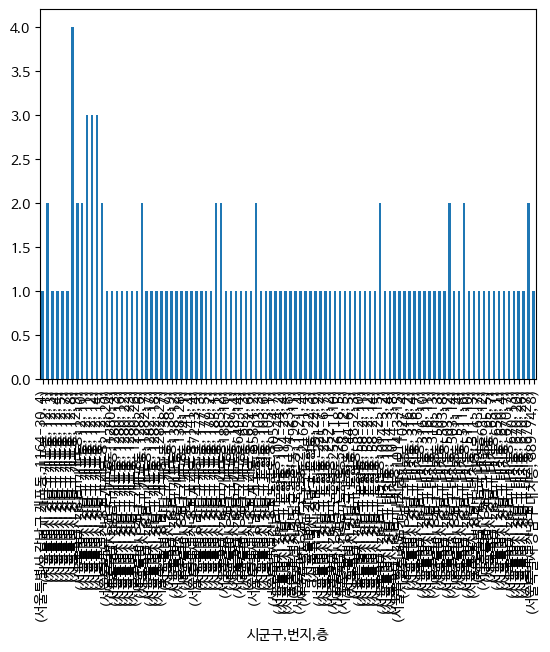

In [14]:
# 취소된 거래의 개수를 주소 및 층 기준으로 앞에서 100개 추출
canceled_transaction['target'][:100].plot(kind='bar')

In [16]:
# 취소가 3번 이상 된 집들은 이상하게 생각
# 총 123개 층
canceled_transaction[canceled_transaction['target'] >= 3].count()

본번                        123
부번                        123
아파트명                      123
전용면적(㎡)                   123
계약년월                      123
계약일                       123
건축년도                      123
도로명                       123
해제사유발생일                   123
등기신청일자                    123
거래유형                      123
중개사소재지                    123
k-단지분류(아파트,주상복합등등)        123
k-전화번호                    123
k-팩스번호                    123
단지소개기존clob                123
k-세대타입(분양형태)              123
k-관리방식                    123
k-복도유형                    123
k-난방방식                    123
k-전체동수                    123
k-전체세대수                   123
k-건설사(시공사)                123
k-시행사                     123
k-사용검사일-사용승인일             123
k-연면적                     123
k-주거전용면적                  123
k-관리비부과면적                 123
k-전용면적별세대현황(60㎡이하)        123
k-전용면적별세대현황(60㎡~85㎡이하)    123
k-85㎡~135㎡이하              123
k-135㎡초과                  123
k-홈페이지                    123
k-등록일자    

<Axes: xlabel='시군구,번지,층'>

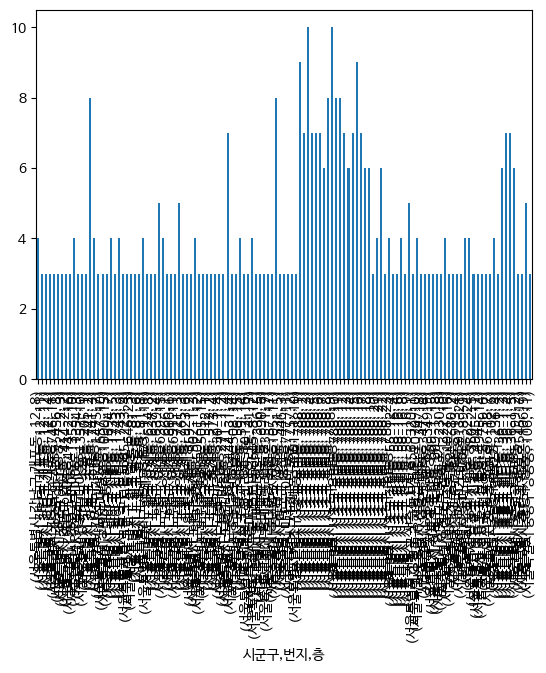

In [18]:
# 한 아파트 한층에서 최대 10개의 취소건수까지 나옴

canceled_transaction[canceled_transaction['target'] >= 3]['target'].plot(kind='bar')

<Axes: xlabel='시군구,번지,층'>

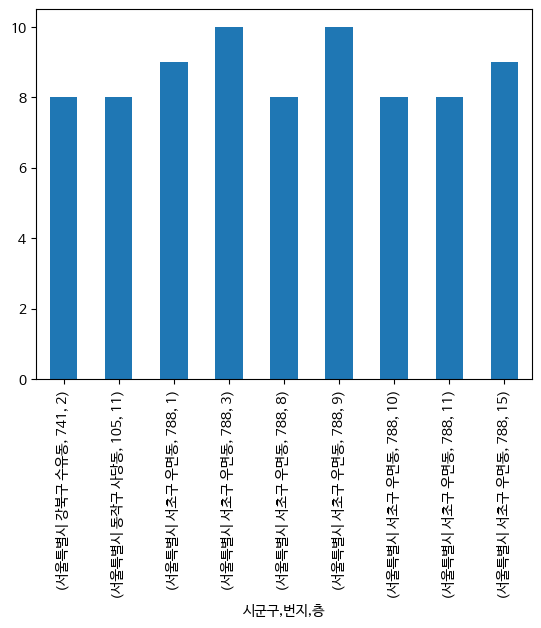

In [159]:
# 취소건수 8개 이상의 경우를 확인
canceled_transaction[canceled_transaction['target'] >= 8]['target'].plot(kind='bar')

In [42]:
# 날자 확인을 위해 변수를 생성

canceled_transaction_about_address = dt.copy()
canceled_transaction_about_address['address'] = dt['시군구'] + ' ' + dt['번지'] + ' ' + dt['층'].astype(str)

In [43]:
canceled_transaction_about_address['address']

0          서울특별시 강남구 개포동 658-1 3
1          서울특별시 강남구 개포동 658-1 4
2          서울특별시 강남구 개포동 658-1 5
3          서울특별시 강남구 개포동 658-1 4
4          서울특별시 강남구 개포동 658-1 2
                   ...          
1118817     서울특별시 은평구 구산동 382 11
1118818     서울특별시 은평구 구산동 382 10
1118819     서울특별시 은평구 구산동 382 20
1118820      서울특별시 은평구 구산동 382 8
1118821     서울특별시 중구 묵정동 11-67 5
Name: address, Length: 1118822, dtype: object

In [184]:
a = canceled_transaction_about_address[ ~ canceled_transaction_about_address['해제사유발생일'].isna()].loc[:, ['address', '계약년월', '계약일', '해제사유발생일', 'target']]\
    .sort_values(['address', '계약년월'])
a

address    계약년월  계약일     해제사유발생일  target
294646  서울특별시 강남구 개포동 1164-30 4  202008    3  20200924.0   62000
294789       서울특별시 강남구 개포동 12 1  202006   13  20201030.0  100000
202416       서울특별시 강남구 개포동 12 1  202303   11  20230329.0  100000
294761      서울특별시 강남구 개포동 12 10  202002   21  20200325.0  123500
238739      서울특별시 강남구 개포동 12 10  202011   14  20210216.0  136000
...                         ...     ...  ...         ...     ...
294542      서울특별시 중랑구 중화동 450 3  202012    9  20210406.0   75000
352137                      NaN  202007    5  20200731.0  134000
271017                      NaN  202101   12  20210412.0  160000
230628                      NaN  202110   13  20211202.0  178000
212643                      NaN  202306   10  20230628.0  139000

[5983 rows x 5 columns]

In [190]:
# 계약 취소가 10회 이상인 케이스
a[a['address'] == '서울특별시 서초구 우면동 788 3']

address    계약년월  계약일     해제사유발생일  target
356715  서울특별시 서초구 우면동 788 3  202007   20  20220211.0   55800
356735  서울특별시 서초구 우면동 788 3  202008   25  20220617.0   67400
356748  서울특별시 서초구 우면동 788 3  202009   11  20220211.0   55250
356751  서울특별시 서초구 우면동 788 3  202009   18  20220211.0   54450
274410  서울특별시 서초구 우면동 788 3  202012   21  20220211.0   67400
274444  서울특별시 서초구 우면동 788 3  202101   25  20220211.0   54450
274457  서울특별시 서초구 우면동 788 3  202103    3  20220211.0   67400
274461  서울특별시 서초구 우면동 788 3  202103    5  20220211.0   55800
274463  서울특별시 서초구 우면동 788 3  202103    8  20210813.0  115000
274477  서울특별시 서초구 우면동 788 3  202103   15  20220211.0   67400

### 해재 사유 발생일

- 이 컬럼은 계약이 취소된 날자
- 해당 계약은 계약이 성사되지 않았으니 가격을 예측에서 제외해야하는가?
- 아니면 계약 취소 여부의 다른 변수로 제작
 
- 5983개의 데이터 존재


    - 일정 개수가 넘거나 모든 취소건수는 삭제처리?? or 취소됐다는 변수를 만든다??

#### 결론 : 해당 아파트의 특정 층이 계약과 취소를 반복한 케이스 확인
- 특정구, 번지, 층의 거래가 반복적으로 계약과 취소를 한케이스 확인
- 한 두번의 케이스를 무시해도 3번이상 많게는 열댓번을 반복하기도 함
- 가장 거래 취소가 많은 케이스를 확인해 보니 계약일은 다른데 취소일이 같은 경우가 보임

`예상`
- 이것이 의미하는 바가 정말 서로 다른 집을 게약하고 같은 날에 모두 취소했다? 혹은 정말 가격을 올리려고 작당 했다? 혹은 같은 집을 반복해서 계약과 취소를 했다?
- 단순히 10개의 거래가 있으니 단지에 10동이 존재하고 이들 모두 거래가 취소된것이다?
- 실제로 검색해본 결과 해당 주소의 아파트는 모두 12동 존재
- 단순히 진짜 모든 동의 1층이 계약 취소 된것 일 수 있음 >> 단순히 1충이 인기가 없음??

`확인 필요사항`
- 정말 집값을 올리려고 계약과 취소를 반복한 것인지 확인필요??
- 모든 케이스가 하나의 집에서 발생한것인지?
- 시간상 얼마나 연속적으로 발생한 것인지?
- 가장 유력한 예상 > 아마 주소와 층이 같아도 다른동에 대한 것일 수 있음

`생성 가능 피쳐`
- 단순히 거래가 취소된 여부
- 경우에 따라서는 거래가를 임의로 조작하려고 시도한 것으로 보고 학습에서 제외 시켜야 하는가?

`추가 EDA 사항`
- 계약이 취소된 곳들의 공통점
- 시군구, 층, 건축년도, 전용면적등...
- 층을 제외한 같은 단지내 계약이 취소된 거래의 양

#### 추가 EDA
- 해당 층만이 아닌 다른 층들에 대해서도 추출해본 결과
- 다른 층들도 대체로 같은 날자에 계약이 취소됨
- 일부러 라기 보단 계약을 진행한 후 계약금을 지급하지 못해 분양이 취소된 케이스가 아닐까 예측

In [280]:
# 추가 EDA 
# 서울특별시 서초구 우면동 788의 1층이외 다른 층들의 거래 취소량
# 전체 거래 215건
# 거래 취소 158건
# 거래 성사 57건
dt[(dt['시군구'] == '서울특별시 서초구 우면동') & (dt['번지'] == '788')].loc[:, ['층','계약년월', '계약일', '해제사유발생일', 'target']].sort_values('층')

층    계약년월  계약일     해제사유발생일  target
274377   1  202011   13  20220211.0   63800
274362   1  202010   30  20220211.0   52650
356739   1  202008   28  20220211.0   52150
274426   1  202101    4  20220613.0   63800
356720   1  202008    5  20220211.0   52650
...     ..     ...  ...         ...     ...
216055  24  202303   13         NaN  115000
274382  24  202011   20  20220211.0   71000
274425  25  202101    1         NaN  120000
274383  25  202011   20  20220211.0   70400
274420  25  202012   29  20220211.0   70400

[215 rows x 5 columns]

### 신축과 구축 확인

- 건축년도 분포 확인
- 준공 완료로 부터
    - 5년 이내 : 신축
    - 5 ~ 10년 : 준신축
    - 10년 이상 : 구축

In [91]:
dt['건축년도'].value_counts().sort_index()

1961       54
1965       17
1966      105
1967       17
1968      251
1969      536
1970      688
1971     2396
1972      679
1973     1046
1974     3425
1975     2168
1976     2651
1977     2311
1978     8076
1979     7000
1980     9814
1981     5212
1982    11759
1983    14226
1984    10608
1985     8053
1986    23293
1987    25608
1988    55581
1989    23659
1990    15720
1991    15260
1992    32553
1993    30506
1994    25745
1995    27059
1996    32125
1997    42227
1998    44049
1999    59802
2000    56851
2001    42293
2002    41929
2003    65601
2004    68487
2005    48372
2006    34935
2007    29731
2008    37247
2009    24084
2010    21022
2011    20318
2012    16375
2013    13372
2014    17199
2015     8800
2016     8364
2017     4671
2018     4858
2019     4802
2020     2773
2021     1707
2022      673
2023       79
Name: 건축년도, dtype: int64

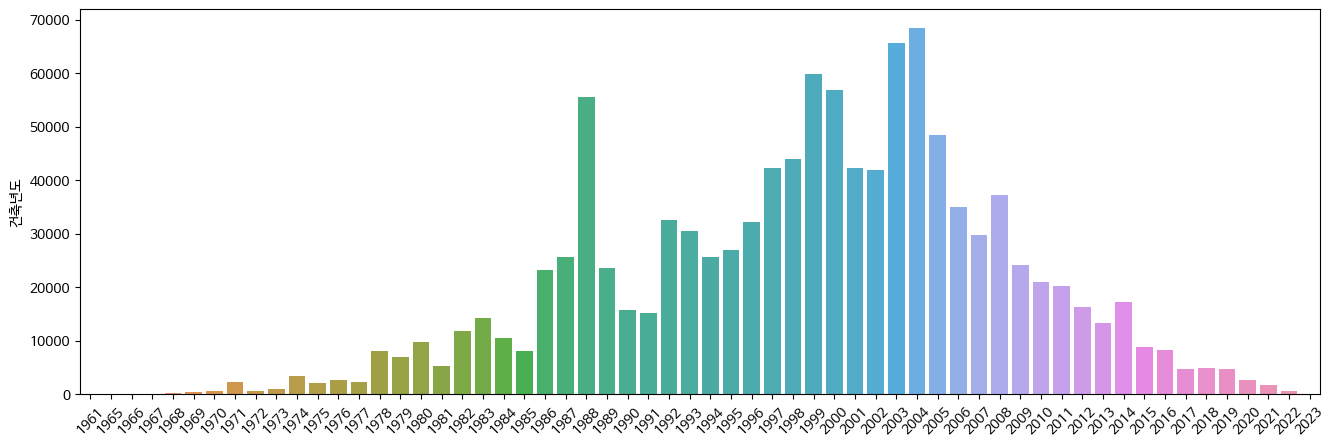

In [97]:
construction_year_distribution = pd.DataFrame(dt['건축년도'].value_counts().sort_index())
fig = plt.figure(figsize=(16, 5))
sns.barplot(data = construction_year_distribution, x=construction_year_distribution.index, y='건축년도')
plt.xticks(rotation = 45)
plt.show()

#### 매매 아파트의 건축년도 분포

- 현제 기준 구축아파트의 거래량이 월등, 신축아파트는 거래량이 비교적 적음 (애초에 대이터 양의 차이가 나는 듯함)
- 애초에 신축의 기준이 너무 좁고 구죽의 기준은 너무 넓음
- 1988, 1998, 1999, 2003, 2004년 건축된 아파트의 거래량이 많음

#### 추가피쳐 > 구매당시의 아파트 연식
- 구매년도에서 건축연도를 뺌

In [139]:
additional_features = dt.copy()
additional_features['구매당시연식'] = (additional_features['계약년월']/100).astype(int) - additional_features['건축년도']
additional_features

시군구     번지     본번    부번    아파트명  전용면적(㎡)    계약년월  계약일   층  \
0        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712    8   3   
1        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712   22   4   
2        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    54.98  201712   28   5   
3        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801    3   4   
4        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801    8   2   
...                ...    ...    ...   ...     ...      ...     ...  ...  ..   
1118817  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200707   12  11   
1118818  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200708   25  10   
1118819  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200708   31  20   
1118820  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200709   15   8   
1118821   서울특별시 중구 묵정동  11-67   11.0  67.0      묵정    52.46  200701   10   5   

         건축년도  ...   주차대수  기타/의무/임대/임의=1/2/3/4                  단지승인일 사용허가여부  \
0        1987  ...  262.0                   임의  2022-11-17 13:00:29.0      Y   
1        1987  ...  262.0                   임의  2022-11-17 13:00:29.0      Y   
2        1987  ...  262.0                   임의  2022-11-17 13:00:29.0      Y   
3        1987  ...  262.0                   임의  2022-11-17 13:00:29.0      Y   
4        1987  ...  262.0                   임의  2022-11-17 13:00:29.0      Y   
...       ...  ...    ...                  ...                    ...    ...   
1118817  1998  ...  366.0                   의무  2013-06-04 16:18:51.0      Y   
1118818  1998  ...  366.0                   의무  2013-06-04 16:18:51.0      Y   
1118819  1998  ...  366.0                   의무  2013-06-04 16:18:51.0      Y   
1118820  1998  ...  366.0                   의무  2013-06-04 16:18:51.0      Y   
1118821  1981  ...   45.0                   임의  2020-07-10 00:00:00.0      Y   

        관리비 업로드         좌표X        좌표Y                  단지신청일  target 구매당시연식  
0             N  127.057210  37.476763  2022-11-17 10:19:06.0  124000     30  
1             N  127.057210  37.476763  2022-11-17 10:19:06.0  123500     30  
2             N  127.057210  37.476763  2022-11-17 10:19:06.0   91500     30  
3             N  127.057210  37.476763  2022-11-17 10:19:06.0  130000     31  
4             N  127.057210  37.476763  2022-11-17 10:19:06.0  117000     31  
...         ...         ...        ...                    ...     ...    ...  
1118817       N  126.905638  37.612962  2013-03-07 09:46:27.0   20000      9  
1118818       N  126.905638  37.612962  2013-03-07 09:46:27.0   20000      9  
1118819       N  126.905638  37.612962  2013-03-07 09:46:27.0   28000      9  
1118820       N  126.905638  37.612962  2013-03-07 09:46:27.0   29000      9  
1118821       Y  127.000071  37.560706  2017-09-05 20:06:39.0   13250     26  

[1118822 rows x 53 columns]

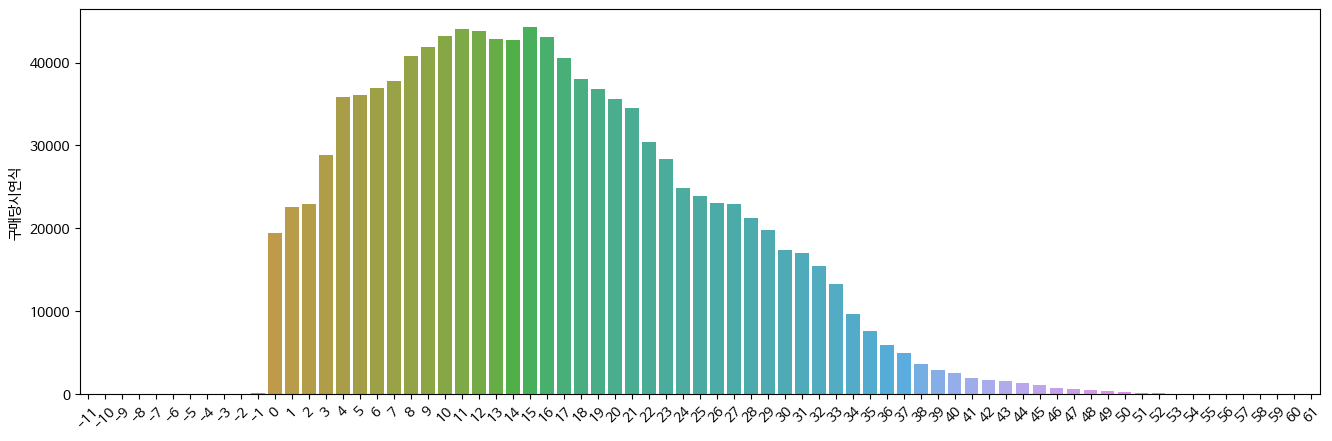

In [141]:
# 구매당시 연식의 분포
tmp = pd.DataFrame(additional_features['구매당시연식'].value_counts().sort_index())
fig = plt.figure(figsize=(16, 5))
sns.barplot(data = tmp, x=tmp.index, y='구매당시연식')
plt.xticks(rotation = 45)
plt.show()

In [156]:
# 집의 계약을 건축보다 빨리하는 케이스가 존재
additional_features[additional_features['구매당시연식'] < 0 ].loc[:, ['계약년월', '건축년도', '구매당시연식', '기타/의무/임대/임의=1/2/3/4', 'k-세대타입(분양형태)']].sort_values('k-세대타입(분양형태)')

계약년월  건축년도  구매당시연식 기타/의무/임대/임의=1/2/3/4 k-세대타입(분양형태)
43541    201806  2019      -1                  의무           기타
378179   202002  2021      -1                  의무           기타
378180   202003  2021      -1                  의무           기타
395419   202011  2021      -1                  의무           기타
437153   201904  2021      -2                  의무           기타
...         ...   ...     ...                 ...          ...
1095391  200709  2018     -11                 NaN          NaN
1095392  200709  2018     -11                 NaN          NaN
1095393  200709  2018     -11                 NaN          NaN
1095394  200709  2018     -11                 NaN          NaN
1095395  200709  2018     -11                 NaN          NaN

[314 rows x 5 columns]

In [158]:
# 연식이 50년 이상의 아파트를 구매한 경우
additional_features[additional_features['구매당시연식'] >=50 ].loc[:, ['계약년월', '건축년도', '구매당시연식', '기타/의무/임대/임의=1/2/3/4', 'k-세대타입(분양형태)']].sort_values('k-세대타입(분양형태)')

계약년월  건축년도  구매당시연식 기타/의무/임대/임의=1/2/3/4 k-세대타입(분양형태)
25392   201803  1961      57                 NaN          NaN
25453   201801  1961      57                 NaN          NaN
25454   201804  1961      57                 NaN          NaN
25455   201711  1967      50                 NaN          NaN
26091   201805  1961      57                 NaN          NaN
...        ...   ...     ...                 ...          ...
677870  201505  1961      54                 NaN          NaN
677871  201509  1961      54                 NaN          NaN
757785  201507  1965      50                 NaN          NaN
863247  201211  1961      51                 NaN          NaN
925500  201108  1961      50                 NaN          NaN

[601 rows x 5 columns]

#### 결론 : 건축보다 계약을 더 빨리한 케이스 존재, 너무 오래된 아파트를 사는 케이스 존재
- 일부는 건축완료 이전에 미리 계약한 것으로 생각가능
- 다만 일부 건축보다 6~11년 까지도 미리 계약한 케이스 존재
- 이는 잠깐 건축이 중단 및 차후 제게된 케이스로 예상

이를 통해 `구매 당시 신축과 구축을 구분하는 피쳐를 생성`

- 다만 `건축보다 계약을 빨리한 경우`는 어떻게 처리할지 `의논` 필요
- 또한, `일정 이상의 연식`의 아파트를 사는 경우는 `투기목적(재개발 가능성)`을 두고 구매한는 경우 일 수있음
- 어느정도의 연식이 재개발 가능성이 있는것인지 `의논` 필요

또한 `재개발 가능성 피처`를 생성할지 의논

### 지역별 거래량
- 구별 거래량
- 번지까지의 거래량
- 아파트별 거래량
- 시공사별 거래량

`확인할 사항`
-> 거래량이 많으면 가격또한 상승할 수 있음
- 사람들은 특정 지역에 관심이 있는 것인지(시군구)
- 특정 단지에 관심이 있는 것이지(번지)
- 특정 아파트 브렌드에 관심이 있는것인지(아파트명)
- 특정 시공사에 관심이 있는지(시공사)

`특정 요소에 대한 선호도 조사`

#### 시군구별 거래량
- 시군구 별 거래량과 거래금액의 변화 확인

In [283]:
# 시군구 별로 그룹화 및 개수 확인
a = dt.groupby('시군구').count()
a

번지     본번     부번   아파트명  전용면적(㎡)   계약년월    계약일      층  \
시군구                                                                       
서울특별시 강남구 개포동  12218  12218  12218  12218    12218  12218  12218  12218   
서울특별시 강남구 논현동   3294   3294   3294   3294     3294   3294   3294   3294   
서울특별시 강남구 대치동  10251  10251  10251  10249    10251  10251  10251  10251   
서울특별시 강남구 도곡동   9532   9532   9532   9532     9532   9532   9532   9532   
서울특별시 강남구 삼성동   5844   5844   5844   5844     5844   5844   5844   5844   
...              ...    ...    ...    ...      ...    ...    ...    ...   
서울특별시 중랑구 면목동   8398   8398   8398   8398     8398   8398   8398   8398   
서울특별시 중랑구 묵동    6113   6113   6113   6113     6113   6113   6113   6113   
서울특별시 중랑구 상봉동   4635   4635   4635   4635     4635   4635   4635   4635   
서울특별시 중랑구 신내동  12684  12684  12684  12684    12684  12684  12684  12684   
서울특별시 중랑구 중화동   2625   2625   2625   2625     2625   2625   2625   2625   

                건축년도    도로명  ...  건축면적  주차대수  기타/의무/임대/임의=1/2/3/4  단지승인일  \
시군구                          ...                                           
서울특별시 강남구 개포동  12218  12218  ...  4529  4529                 4529   4529   
서울특별시 강남구 논현동   3294   3294  ...   585   585                  585    585   
서울특별시 강남구 대치동  10251  10251  ...  4657  4657                 4657   4657   
서울특별시 강남구 도곡동   9532   9532  ...  2805  2805                 2805   2805   
서울특별시 강남구 삼성동   5844   5844  ...   246   246                  246    246   
...              ...    ...  ...   ...   ...                  ...    ...   
서울특별시 중랑구 면목동   8398   8398  ...  1478  1478                 1478   1478   
서울특별시 중랑구 묵동    6113   6113  ...   327   327                  327    327   
서울특별시 중랑구 상봉동   4635   4635  ...   759   759                  759    759   
서울특별시 중랑구 신내동  12684  12684  ...   701   701                  701    701   
서울특별시 중랑구 중화동   2625   2625  ...     0     0                    0      0   

               사용허가여부  관리비 업로드   좌표X   좌표Y  단지신청일  target  
시군구                                                        
서울특별시 강남구 개포동    4529     4529  4529  4529   4529   12218  
서울특별시 강남구 논현동     585      585   585   585    585    3294  
서울특별시 강남구 대치동    4657     4657  4657  4657   4657   10251  
서울특별시 강남구 도곡동    2805     2805  2805  2805   2805    9532  
서울특별시 강남구 삼성동     246      246   201   201    246    5844  
...               ...      ...   ...   ...    ...     ...  
서울특별시 중랑구 면목동    1478     1478  1478  1478   1478    8398  
서울특별시 중랑구 묵동      327      327   327   327    327    6113  
서울특별시 중랑구 상봉동     759      759   759   759    759    4635  
서울특별시 중랑구 신내동     701      701   701   701    701   12684  
서울특별시 중랑구 중화동       0        0     0     0      0    2625  

[339 rows x 51 columns]

시군구
서울특별시 노원구 상계동    44948
서울특별시 노원구 중계동    26357
서울특별시 양천구 신정동    23569
서울특별시 도봉구 창동     23101
서울특별시 구로구 구로동    22811
서울특별시 관악구 봉천동    20511
서울특별시 양천구 목동     17246
서울특별시 노원구 월계동    17056
서울특별시 서초구 서초동    15899
서울특별시 노원구 공릉동    15763
Name: target, dtype: int64

<Axes: xlabel='시군구'>

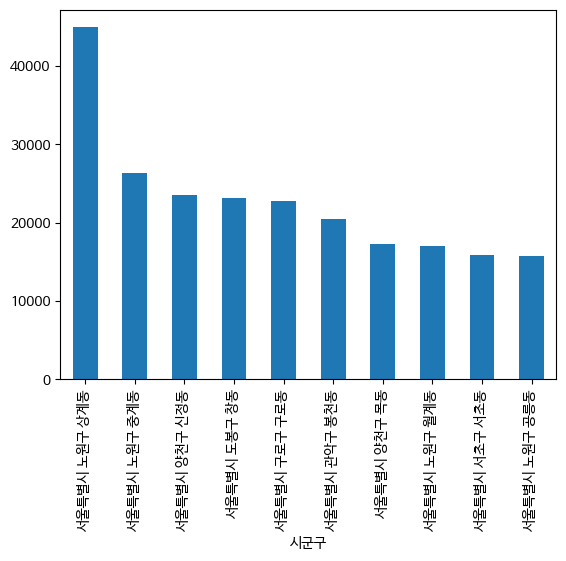

In [284]:
# 전체기간 거래량 상위 10개
# 노원구, 양천구, 도봉구, 구로구, 관악구, 양천구, 서초구
display(a['target'].sort_values(ascending=False)[:10])
a['target'].sort_values(ascending=False)[:10].plot(kind='bar')

In [285]:
# 거래량 상위 10개의 평균 가격
a2 = dt.groupby('시군구').mean()

시군구
서울특별시 노원구 상계동    31354.066054
서울특별시 노원구 중계동    38140.255188
서울특별시 양천구 신정동    58810.911324
서울특별시 도봉구 창동     34245.628328
서울특별시 구로구 구로동    33323.453685
서울특별시 관악구 봉천동    45073.968895
서울특별시 양천구 목동     79382.108605
서울특별시 노원구 월계동    33239.980183
서울특별시 서초구 서초동    97847.094346
서울특별시 노원구 공릉동    32597.442555
Name: target, dtype: float64

<Axes: xlabel='시군구'>

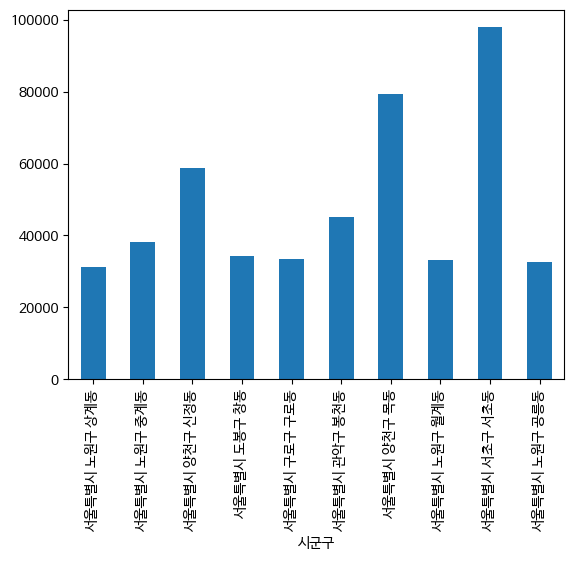

In [286]:
# 전체기간 거래량 상위 10개
display(a2.loc[['서울특별시 노원구 상계동',
        '서울특별시 노원구 중계동',
        '서울특별시 양천구 신정동',
        '서울특별시 도봉구 창동',
        '서울특별시 구로구 구로동',
        '서울특별시 관악구 봉천동',
        '서울특별시 양천구 목동',
        '서울특별시 노원구 월계동',
        '서울특별시 서초구 서초동',
        '서울특별시 노원구 공릉동',], 'target'])
a2.loc[['서울특별시 노원구 상계동',
        '서울특별시 노원구 중계동',
        '서울특별시 양천구 신정동',
        '서울특별시 도봉구 창동',
        '서울특별시 구로구 구로동',
        '서울특별시 관악구 봉천동',
        '서울특별시 양천구 목동',
        '서울특별시 노원구 월계동',
        '서울특별시 서초구 서초동',
        '서울특별시 노원구 공릉동',], 'target'].plot(kind='bar')

#### 시군구 + 번지 별 거래량
- 시군구 + 번지 별 거래량과 거래금액의 변화 확인

In [235]:
# 시군구, 번지 별로 그룹화 및 개수 확인
a = dt.groupby(['시군구', '번지']).count()
a

본번    부번  아파트명  전용면적(㎡)  계약년월   계약일     층  건축년도  \
시군구           번지                                                           
서울특별시 강남구 개포동 1164-12     9     9     9        9     9     9     9     9   
              1164-13    14    14    14       14    14    14    14    14   
              1164-14    15    15    15       15    15    15    15    15   
              1164-20     7     7     7        7     7     7     7     7   
              1164-25     4     4     4        4     4     4     4     4   
...                     ...   ...   ...      ...   ...   ...   ...   ...   
서울특별시 중랑구 중화동 438        80    80    80       80    80    80    80    80   
              450      1462  1462  1462     1462  1462  1462  1462  1462   
              452        53    53    53       53    53    53    53    53   
              453        82    82    82       82    82    82    82    82   
              454        79    79    79       79    79    79    79    79   

                        도로명  해제사유발생일  ...  건축면적  주차대수  기타/의무/임대/임의=1/2/3/4  \
시군구           번지                      ...                                    
서울특별시 강남구 개포동 1164-12     9        0  ...     0     0                    0   
              1164-13    14        0  ...     0     0                    0   
              1164-14    15        0  ...     0     0                    0   
              1164-20     7        0  ...     0     0                    0   
              1164-25     4        0  ...     0     0                    0   
...                     ...      ...  ...   ...   ...                  ...   
서울특별시 중랑구 중화동 438        80        1  ...     0     0                    0   
              450      1462        9  ...     0     0                    0   
              452        53        0  ...     0     0                    0   
              453        82        0  ...     0     0                    0   
              454        79        0  ...     0     0                    0   

                       단지승인일  사용허가여부  관리비 업로드  좌표X  좌표Y  단지신청일  target  
시군구           번지                                                        
서울특별시 강남구 개포동 1164-12      0       0        0    0    0      0       9  
              1164-13      0       0        0    0    0      0      14  
              1164-14      0       0        0    0    0      0      15  
              1164-20      0       0        0    0    0      0       7  
              1164-25      0       0        0    0    0      0       4  
...                      ...     ...      ...  ...  ...    ...     ...  
서울특별시 중랑구 중화동 438          0       0        0    0    0      0      80  
              450          0       0        0    0    0      0    1462  
              452          0       0        0    0    0      0      53  
              453          0       0        0    0    0      0      82  
              454          0       0        0    0    0      0      79  

[8941 rows x 50 columns]

시군구            번지   
서울특별시 송파구 신천동  17       4322
서울특별시 강북구 미아동  1353     3997
서울특별시 동작구 사당동  105      3585
서울특별시 성북구 돈암동  609-1    3487
서울특별시 노원구 중계동  502-1    3316
서울특별시 관악구 봉천동  1712     3157
서울특별시 송파구 가락동  479      3119
서울특별시 송파구 잠실동  22       3056
               19       3028
서울특별시 도봉구 방학동  271-1    2998
Name: target, dtype: int64


<Axes: xlabel='시군구,번지'>

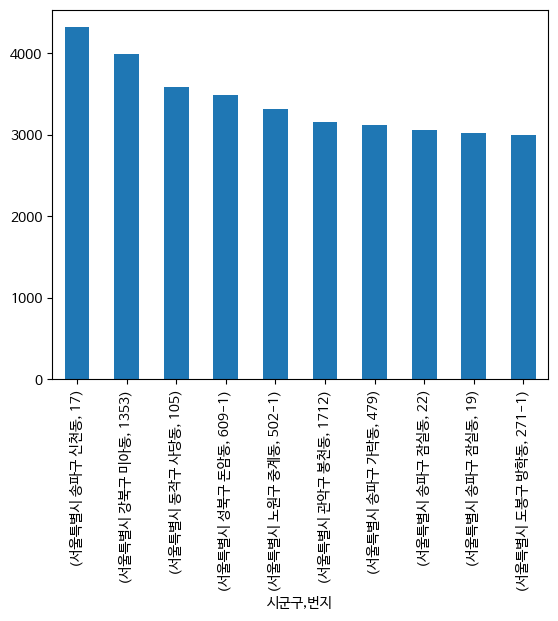

In [239]:
# 전체기간 거래량 상위 10개
print(a['target'].sort_values(ascending=False)[:10])
a['target'].sort_values(ascending=False)[:10].plot(kind='bar')

In [240]:
# 거래량 상위 10개의 평균 가격

a2 = dt.groupby(['시군구', '번지']).mean()
a2

본번    부번    전용면적(㎡)           계약년월        계약일  \
시군구           번지                                                           
서울특별시 강남구 개포동 1164-12  1164.0  12.0  73.302222  201428.666667  21.777778   
              1164-13  1164.0  13.0  59.794286  201463.642857  15.857143   
              1164-14  1164.0  14.0  54.414000  201595.133333  16.666667   
              1164-20  1164.0  20.0  72.780000  201606.285714  14.571429   
              1164-25  1164.0  25.0  83.890000  201604.000000  17.500000   
...                       ...   ...        ...            ...        ...   
서울특별시 중랑구 중화동 438       438.0   0.0  70.140000  201464.625000  16.962500   
              450       450.0   0.0  64.631785  201440.987004  15.626539   
              452       452.0   0.0  78.564717  201313.754717  15.679245   
              453       453.0   0.0  84.119268  201396.012195  15.621951   
              454       454.0   0.0  89.911392  201630.329114  16.405063   

                               층         건축년도       해제사유발생일  단지소개기존clob  \
시군구           번지                                                          
서울특별시 강남구 개포동 1164-12   4.444444  2000.000000           NaN         NaN   
              1164-13   5.500000  2000.000000           NaN         NaN   
              1164-14   3.800000  2000.000000           NaN         NaN   
              1164-20   4.428571  2002.000000           NaN         NaN   
              1164-25   4.750000  2002.000000           NaN         NaN   
...                          ...          ...           ...         ...   
서울특별시 중랑구 중화동 438       7.637500  1995.000000  2.022112e+07         NaN   
              450      13.393981  1997.131327  2.020725e+07         NaN   
              452       8.396226  2001.000000           NaN         NaN   
              453       7.731707  2007.000000           NaN         NaN   
              454      10.126582  2013.000000           NaN         NaN   

                       k-전체동수  ...  k-관리비부과면적  k-전용면적별세대현황(60㎡이하)  \
시군구           번지               ...                                  
서울특별시 강남구 개포동 1164-12     NaN  ...        NaN                 NaN   
              1164-13     NaN  ...        NaN                 NaN   
              1164-14     NaN  ...        NaN                 NaN   
              1164-20     NaN  ...        NaN                 NaN   
              1164-25     NaN  ...        NaN                 NaN   
...                       ...  ...        ...                 ...   
서울특별시 중랑구 중화동 438         NaN  ...        NaN                 NaN   
              450         NaN  ...        NaN                 NaN   
              452         NaN  ...        NaN                 NaN   
              453         NaN  ...        NaN                 NaN   
              454         NaN  ...        NaN                 NaN   

                       k-전용면적별세대현황(60㎡~85㎡이하)  k-85㎡~135㎡이하  k-135㎡초과  건축면적  \
시군구           번지                                                              
서울특별시 강남구 개포동 1164-12                     NaN           NaN       NaN   NaN   
              1164-13                     NaN           NaN       NaN   NaN   
              1164-14                     NaN           NaN       NaN   NaN   
              1164-20                     NaN           NaN       NaN   NaN   
              1164-25                     NaN           NaN       NaN   NaN   
...                                       ...           ...       ...   ...   
서울특별시 중랑구 중화동 438                         NaN           NaN       NaN   NaN   
              450                         NaN           NaN       NaN   NaN   
              452                         NaN           NaN       NaN   NaN   
              453                         NaN           NaN       NaN   NaN   
              454                         NaN           NaN       NaN   NaN   

                       주차대수  좌표X  좌표Y        target  
시군구           번지                                     
서울특별시 강남구 개포동 1164-12   NaN 

시군구            번지   
서울특별시 송파구 신천동  17       111071.047432
서울특별시 강북구 미아동  1353      40386.312985
서울특별시 동작구 사당동  105       55826.793026
서울특별시 성북구 돈암동  609-1     43278.207342
서울특별시 노원구 중계동  502-1     25976.653800
서울특별시 관악구 봉천동  1712      47727.042129
서울특별시 송파구 가락동  479       59485.008015
서울특별시 송파구 잠실동  22       113316.553665
               19       118830.495046
서울특별시 도봉구 방학동  271-1     25087.646097
Name: target, dtype: float64

<Axes: xlabel='시군구,번지'>

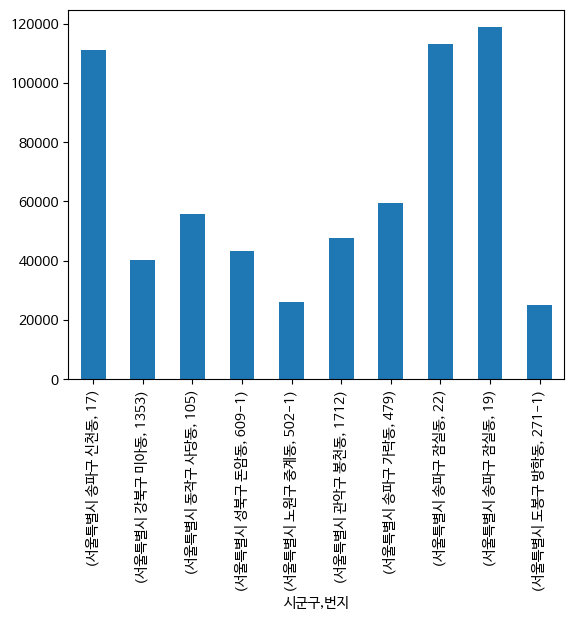

In [245]:
# 전체기간 거래량 상위 10개
display(a2.loc[[('서울특별시 송파구 신천동',    '17'),
            ('서울특별시 강북구 미아동',  '1353'),
            ('서울특별시 동작구 사당동',   '105'),
            ('서울특별시 성북구 돈암동', '609-1'),
            ('서울특별시 노원구 중계동', '502-1'),
            ('서울특별시 관악구 봉천동',  '1712'),
            ('서울특별시 송파구 가락동',   '479'),
            ('서울특별시 송파구 잠실동',    '22'),
            ('서울특별시 송파구 잠실동',    '19'),
            ('서울특별시 도봉구 방학동', '271-1')], 'target'])
a2.loc[[('서울특별시 송파구 신천동',    '17'),
            ('서울특별시 강북구 미아동',  '1353'),
            ('서울특별시 동작구 사당동',   '105'),
            ('서울특별시 성북구 돈암동', '609-1'),
            ('서울특별시 노원구 중계동', '502-1'),
            ('서울특별시 관악구 봉천동',  '1712'),
            ('서울특별시 송파구 가락동',   '479'),
            ('서울특별시 송파구 잠실동',    '22'),
            ('서울특별시 송파구 잠실동',    '19'),
            ('서울특별시 도봉구 방학동', '271-1')], 'target'].plot(kind='bar')

#### 아파트(아파트명)별 거래량
- 아파트명 별 거래량과 거래금액의 변화 확인

In [295]:
# 아파트명 별로 그룹화 및 개수 확인
a = dt.groupby('아파트명').count()
a

시군구   번지   본번   부번  전용면적(㎡)  계약년월  계약일    층  건축년도  도로명  ...  건축면적  \
아파트명                                                              ...         
153-25      3    3    3    3        3     3    3    3     3    3  ...     0   
201호 미공시    1    1    1    1        1     1    1    1     1    1  ...     0   
2차한양      438  438  438  438      438   438  438  438   438  438  ...     0   
3RU-City   66   66   66   66       66    66   66   66    66   66  ...     0   
3차신성미소지움   83   83   83   83       83    83   83   83    83   83  ...     0   
...       ...  ...  ...  ...      ...   ...  ...  ...   ...  ...  ...   ...   
힐탑트레져1동    43   43   43   43       43    43   43   43    43   43  ...     0   
힐튼         18   18   18   18       18    18   18   18    18   18  ...     0   
힐튼빌리지1차    13   13   13   13       13    13   13   13    13   13  ...     0   
힐튼빌리지2차    14   14   14   14       14    14   14   14    14   14  ...     0   
힐하우스       24   24   24   24       24    24   24   24    24   24  ...     0   

          주차대수  기타/의무/임대/임의=1/2/3/4  단지승인일  사용허가여부  관리비 업로드  좌표X  좌표Y  단지신청일  \
아파트명                                                                           
153-25       0                    0      0       0        0    0    0      0   
201호 미공시     0                    0      0       0        0    0    0      0   
2차한양         0                    0      0       0        0    0    0      0   
3RU-City     0                    0      0       0        0    0    0      0   
3차신성미소지움     0                    0      0       0        0    0    0      0   
...        ...                  ...    ...     ...      ...  ...  ...    ...   
힐탑트레져1동      0                    0      0       0        0    0    0      0   
힐튼           0                    0      0       0        0    0    0      0   
힐튼빌리지1차      0                    0      0       0        0    0    0      0   
힐튼빌리지2차      0                    0      0       0        0    0    0      0   
힐하우스         0                    0      0       0        0    0    0      0   

          target  
아파트명              
153-25         3  
201호 미공시       1  
2차한양         438  
3RU-City      66  
3차신성미소지움      83  
...          ...  
힐탑트레져1동       43  
힐튼            18  
힐튼빌리지1차       13  
힐튼빌리지2차       14  
힐하우스          24  

[6538 rows x 51 columns]

아파트명
현대       16644
신동아      12846
한신        9074
두산        8533
주공2       7918
우성        7768
벽산        7285
삼성래미안     7143
대림        6305
극동        5669
Name: target, dtype: int64


<Axes: xlabel='아파트명'>

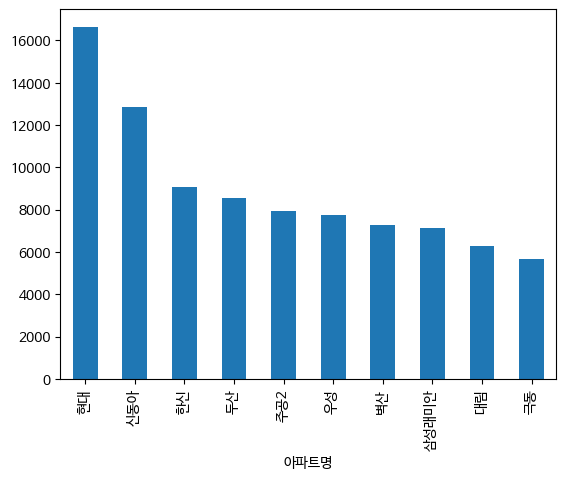

In [296]:
# 전체기간 거래량 상위 10개
print(a['target'].sort_values(ascending=False)[:10])
a['target'].sort_values(ascending=False)[:10].plot(kind='bar')

In [299]:
# 거래량 상위 10개의 평균 가격

a2 = dt.groupby('아파트명').mean()
a2

본번         부번     전용면적(㎡)           계약년월        계약일  \
아파트명                                                                     
153-25     153.000000  25.000000   30.070000  201204.000000  19.000000   
201호 미공시   578.000000   5.000000  158.180000  201503.000000   9.000000   
2차한양       151.000000   0.000000  102.747237  201438.356164  16.367580   
3RU-City   510.000000   2.000000   19.408636  201862.348485  13.030303   
3차신성미소지움  1045.000000   0.000000   80.327952  201335.590361  15.349398   
...               ...        ...         ...            ...        ...   
힐탑트레져1동      1.000000  44.000000  209.885349  201404.441860  15.558140   
힐튼         327.000000  15.000000   72.482222  201123.833333  14.666667   
힐튼빌리지1차    244.000000  91.000000  104.194615  201267.923077  15.230769   
힐튼빌리지2차    244.000000  88.000000  147.439286  201457.142857  15.285714   
힐하우스       523.916667  26.083333  174.402500  201117.750000  15.625000   

                 층      건축년도     해제사유발생일  단지소개기존clob  k-전체동수  ...  k-관리비부과면적  \
아파트명                                                          ...              
153-25    2.666667  1969.000         NaN         NaN     NaN  ...        NaN   
201호 미공시  2.000000  1973.000         NaN         NaN     NaN  ...        NaN   
2차한양      6.648402  1984.000  20200304.0         NaN     NaN  ...        NaN   
3RU-City  7.424242  2013.000  20215973.0         NaN     NaN  ...        NaN   
3차신성미소지움  5.457831  2007.000         NaN         NaN     NaN  ...        NaN   
...            ...       ...         ...         ...     ...  ...        ...   
힐탑트레져1동   6.697674  2003.000         NaN         NaN     NaN  ...        NaN   
힐튼        2.611111  2007.000         NaN         NaN     NaN  ...        NaN   
힐튼빌리지1차   3.384615  2002.000         NaN         NaN     NaN  ...        NaN   
힐튼빌리지2차   2.714286  2002.000         NaN         NaN     NaN  ...        NaN   
힐하우스      2.916667  2001.625         NaN         NaN     NaN  ...        NaN   

          k-전용면적별세대현황(60㎡이하)  k-전용면적별세대현황(60㎡~85㎡이하)  k-85㎡~135㎡이하  k-135㎡초과  \
아파트명                                                                           
153-25                   NaN                     NaN           NaN       NaN   
201호 미공시                 NaN                     NaN           NaN       NaN   
2차한양                     NaN                     NaN           NaN       NaN   
3RU-City                 NaN                     NaN           NaN       NaN   
3차신성미소지움                 NaN                     NaN           NaN       NaN   
...                      ...                     ...           ...       ...   
힐탑트레져1동                  NaN                     NaN           NaN       NaN   
힐튼                       NaN                     NaN           NaN       NaN   
힐튼빌리지1차                  NaN                     NaN           NaN       NaN   
힐튼빌리지2차                  NaN                     NaN           NaN       NaN   
힐하우스                     NaN                     NaN           NaN       NaN   

          건축면적  주차대수  좌표X  좌표Y         target  
아파트명                                           
153-25     NaN   NaN  NaN  NaN   19998.333333  
201호 미공시   NaN   NaN  NaN  NaN   42000.000000  
2차한양       NaN   NaN  NaN  NaN   85100.979452  
3RU-City   NaN   NaN  NaN  NaN   19573.484848  
3차신성미소지움   NaN   NaN  NaN  NaN   32599.638554  
...        ...   ...  ...  ...            ...  
힐탑트레져1동    NaN   NaN  NaN  NaN  258157.627907  
힐튼         NaN   NaN  NaN  NaN   21674.166667  
힐튼빌리지1차    NaN   NaN  NaN  NaN   54192.307692  
힐튼빌리지2차    NaN   NaN  NaN  NaN   75785.714286  
힐하우스       NaN   NaN  NaN  NaN   85225.000000  

[6538 rows x 23 columns]

아파트명
현대       51306.629897
신동아      49563.356453
한신       42977.925171
두산       44493.233681
주공2      31952.765092
우성       59164.242920
벽산       37237.862594
삼성래미안    57334.670447
대림       65605.157653
극동       46086.119598
Name: target, dtype: float64

<Axes: xlabel='아파트명'>

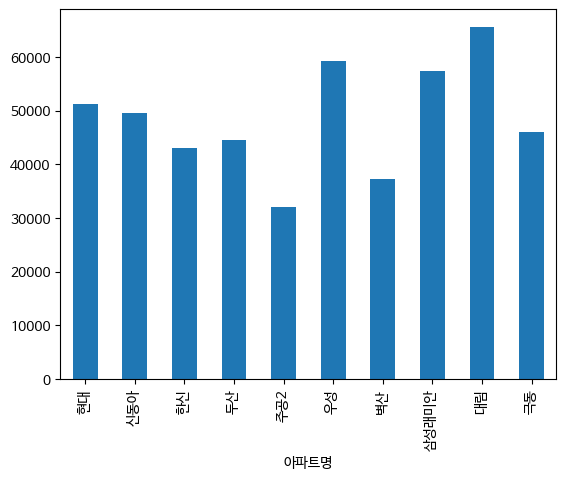

In [301]:
# 전체기간 거래량 상위 10개
display(a2.loc[['현대', '신동아', '한신', '두산', '주공2', '우성', '벽산', '삼성래미안', '대림', '극동'], 'target'])
a2.loc[['현대', '신동아', '한신', '두산', '주공2', '우성', '벽산', '삼성래미안', '대림', '극동'], 'target'].plot(kind='bar')

#### 시공사별 거래량
- 시공사 별 거래량과 거래금액의 변화 확인

In [307]:
# 아파트명 별로 그룹화 및 개수 확인
a = dt.groupby('k-건설사(시공사)').count()
a

시군구    번지    본번    부번  아파트명  전용면적(㎡)  계약년월   계약일     층  건축년도  \
k-건설사(시공사)                                                                  
 (주) 건영      149   149   149   149   149      149   149   149   149   149   
 일신건영        151   151   151   151   151      151   151   151   151   151   
(주) 건영      1410  1410  1410  1410  1410     1410  1410  1410  1410  1410   
(주) 신한건설     100   100   100   100   100      100   100   100   100   100   
(주)gs공사      332   332   332   332   332      332   332   332   332   332   
...          ...   ...   ...   ...   ...      ...   ...   ...   ...   ...   
홍익종합건업(주)    324   324   324   324   324      324   324   324   324   324   
효성중공업        250   250   250   250   250      250   250   250   250   250   
흑석5구역재개발조합   395   395   395   395   395      395   395   395   395   395   
흥화공업         198   198   198   198   198      198   198   198   198   198   
흥화공업(주)      123   123   123   123   123      123   123   123   123   123   

            ...  건축면적  주차대수  기타/의무/임대/임의=1/2/3/4  단지승인일  사용허가여부  관리비 업로드  \
k-건설사(시공사)  ...                                                            
 (주) 건영     ...   149   149                  149    149     149      149   
 일신건영       ...   151   151                  151    151     151      151   
(주) 건영      ...  1410  1410                 1410   1410    1410     1410   
(주) 신한건설    ...   100   100                  100    100     100      100   
(주)gs공사     ...   332   332                  332    332     332      332   
...         ...   ...   ...                  ...    ...     ...      ...   
홍익종합건업(주)   ...   324   324                  324    324     324      324   
효성중공업       ...   250   250                  250    250     250      250   
흑석5구역재개발조합  ...   395   395                  395    395     395      395   
흥화공업        ...   198   198                  198    198     198      198   
흥화공업(주)     ...   123   123                  123    123     123      123   

             좌표X   좌표Y  단지신청일  target  
k-건설사(시공사)                             
 (주) 건영      149   149    149     149  
 일신건영        151   151    151     151  
(주) 건영      1410  1410   1410    1410  
(주) 신한건설     100   100    100     100  
(주)gs공사      332   332    332     332  
...          ...   ...    ...     ...  
홍익종합건업(주)    324   324    324     324  
효성중공업        250   250    250     250  
흑석5구역재개발조합   395   395    395     395  
흥화공업         198   198    198     198  
흥화공업(주)      123   123    123     123  

[344 rows x 51 columns]

k-건설사(시공사)
삼성물산       14081
대우건설       11454
현대건설       10430
대한주택공사      7643
GS건설        6865
두산건설        6773
현대산업개발      6222
현대건설(주)     4711
동부건설        3773
우성건설        3645
Name: target, dtype: int64


<Axes: xlabel='k-건설사(시공사)'>

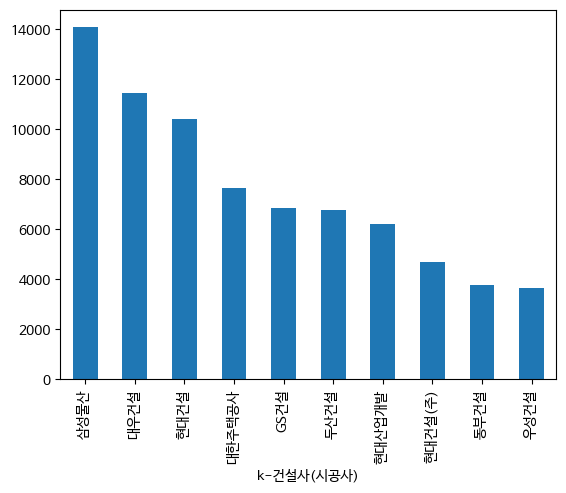

In [308]:
# 전체기간 거래량 상위 10개
print(a['target'].sort_values(ascending=False)[:10])
a['target'].sort_values(ascending=False)[:10].plot(kind='bar')

In [309]:
# 거래량 상위 10개의 평균 가격

a2 = dt.groupby('k-건설사(시공사)').mean()
a2

본번   부번    전용면적(㎡)           계약년월        계약일          층  \
k-건설사(시공사)                                                               
 (주) 건영     393.0  0.0  78.471409  201368.711409  15.040268   9.657718   
 일신건영       456.0  0.0  89.995033  201502.880795  15.417219   6.456954   
(주) 건영      404.0  0.0  77.403801  201451.358156  15.646099  10.875177   
(주) 신한건설     41.0  0.0  69.874200  201501.050000  15.500000   8.500000   
(주)gs공사     821.0  0.0  92.475163  201726.024096  16.481928  16.108434   
...           ...  ...        ...            ...        ...        ...   
홍익종합건업(주)   136.0  0.0  67.238704  201495.682099  14.361111  10.638889   
효성중공업       651.2  0.0  75.081520  201657.652000  16.336000   4.636000   
흑석5구역재개발조합  335.0  0.0  90.425241  201669.579747  15.898734   8.600000   
흥화공업        939.0  0.0  81.239242  201428.040404  15.247475   8.070707   
흥화공업(주)     930.0  1.0  92.365528  201350.040650  14.382114   6.707317   

                건축년도       해제사유발생일  단지소개기존clob  k-전체동수  ...  k-관리비부과면적  \
k-건설사(시공사)                                              ...              
 (주) 건영     2002.000           NaN         NaN   2.000  ...   22589.00   
 일신건영       2008.000           NaN         NaN   4.000  ...   21656.00   
(주) 건영      1998.000  2.021533e+07         NaN  19.000  ...  218984.00   
(주) 신한건설    1997.000           NaN         NaN   1.000  ...   13335.00   
(주)gs공사     2014.000  2.022041e+07         NaN   8.000  ...   76916.00   
...              ...           ...         ...     ...  ...        ...   
홍익종합건업(주)   1999.000  2.020072e+07       122.0   4.000  ...   35286.00   
효성중공업       2002.572  2.021624e+07      2000.0  11.384  ...   38882.54   
흑석5구역재개발조합  2011.000  2.020098e+07       789.0  10.000  ...   70869.00   
흥화공업        2004.000           NaN         NaN   4.000  ...   24310.00   
흥화공업(주)     2006.000           NaN         NaN   2.000  ...   15462.00   

            k-전용면적별세대현황(60㎡이하)  k-전용면적별세대현황(60㎡~85㎡이하)  k-85㎡~135㎡이하  \
k-건설사(시공사)                                                             
 (주) 건영                 57.000                  98.000          51.0   
 일신건영                    0.000                 149.000          48.0   
(주) 건영                 895.000                 632.000         509.0   
(주) 신한건설                44.000                  90.000           0.0   
(주)gs공사                203.000                 519.000          56.0   
...                        ...                     ...           ...   
홍익종합건업(주)              212.000                 168.000           0.0   
효성중공업                   56.964                 351.036           0.0   
흑석5구역재개발조합             138.000                 391.000         126.0   
흥화공업                    26.000                 207.000           0.0   
흥화공업(주)                  0.000                 116.000          45.0   

            k-135㎡초과          건축면적     주차대수         좌표X        좌표Y  \
k-건설사(시공사)                                                           
 (주) 건영          NaN  1.615000e+03   250.00  126.911767  37.568831   
 일신건영            NaN  2.674280e+03   254.00  126.912154  37.577385   
(주) 건영           NaN  0.000000e+00  2173.00  126.973556  37.521378   
(주) 신한건설         NaN  8.578900e+02   129.00  126.933230  37.511960   
(주)gs공사          NaN  5.834339e+06  1176.00  126.900177  37.510395   
...              ...           ...      ...         ...        ...   
홍익종합건업(주)        NaN  2.501970e+03   311.00  127.039375  37.626183   
효성중공업            NaN  2.400767e+04   418.64  127.043748  37.615468   
흑석5구역재개발조합       NaN  6.834840e+03   834.00  126.965281  37.506220   
흥화공업             NaN  2.010290e+03   252.00  127.043980  37.631687   
흥화공업(주)          NaN  1.317860e+03   218.00  126.991933  37.483526   

                  target  
k-건설사(시공사)                
 (주) 건영     42141.946309  
 일신건영       44633.112583  
(주) 건영      96474.523404  
(주) 신한건설    36649.200000  
(주)gs공사     78271.780120  
...                  ...  
홍익종합건업(주)   29916.666667 

k-건설사(시공사)
삼성물산       102487.485477
대우건설        61018.568972
현대건설        60408.023394
대한주택공사      56035.637315
GS건설       135679.915368
두산건설        40611.072346
현대산업개발      66686.515108
현대건설(주)     74773.793462
동부건설        51990.380864
우성건설        50860.499314
Name: target, dtype: float64

<Axes: xlabel='k-건설사(시공사)'>

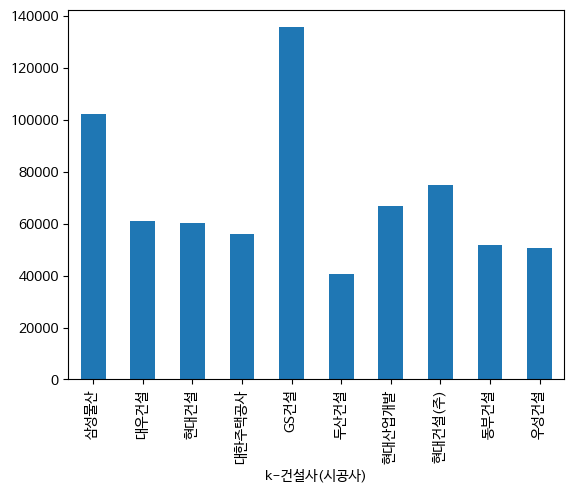

In [311]:
# 전체기간 거래량 상위 10개
display(a2.loc[['삼성물산', '대우건설', '현대건설', '대한주택공사', 'GS건설', '두산건설', '현대산업개발', '현대건설(주)',
                '동부건설', '우성건설'], 'target'])
a2.loc[['삼성물산', '대우건설', '현대건설', '대한주택공사', 'GS건설', '두산건설', '현대산업개발', '현대건설(주)',
        '동부건설', '우성건설'], 'target'].plot(kind='bar')

#### 결론 > 거래량이 많은 경우에 무조건 평균가격이 높게 책정된다고 보기 힘듦 
많은 거래가 이루어진다고 가격이 높아진다고 말하기에는 놓친 변수가 많음 <br>
그래프를 전체기간으로 따졌기에 대략적인 경향파악은 될지언정 정확히는 알수 없음<br>
기간별로 나누어서 확인한다면 더 정확한 경향성 파악이 될것으로 예상

### 연도별, 월별 거래데이터 시각화
- 연도별 거래량
- 전체 통합 월별 거래량
- 각 연도에서 월별 거래량
- 위의 지역별 거래량을 연도까지 고려하여 재확인

#### 연도별 거래량

In [3]:
dt_year_month = dt.copy()

In [4]:
dt_year_month['계약년'] = (dt_year_month['계약년월']/100).astype(int)
dt_year_month['계약월'] = (dt_year_month['계약년월']%100).astype(int)
dt_year_month

시군구     번지     본번    부번    아파트명  전용면적(㎡)    계약년월  계약일   층  \
0        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712    8   3   
1        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201712   22   4   
2        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    54.98  201712   28   5   
3        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801    3   4   
4        서울특별시 강남구 개포동  658-1  658.0   1.0  개포6차우성    79.97  201801    8   2   
...                ...    ...    ...   ...     ...      ...     ...  ...  ..   
1118817  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200707   12  11   
1118818  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    59.94  200708   25  10   
1118819  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200708   31  20   
1118820  서울특별시 은평구 구산동    382  382.0   0.0    갈현현대    84.83  200709   15   8   
1118821   서울특별시 중구 묵정동  11-67   11.0  67.0      묵정    52.46  200701   10   5   

         건축년도  ... 기타/의무/임대/임의=1/2/3/4                  단지승인일 사용허가여부 관리비 업로드  \
0        1987  ...                  임의  2022-11-17 13:00:29.0      Y       N   
1        1987  ...                  임의  2022-11-17 13:00:29.0      Y       N   
2        1987  ...                  임의  2022-11-17 13:00:29.0      Y       N   
3        1987  ...                  임의  2022-11-17 13:00:29.0      Y       N   
4        1987  ...                  임의  2022-11-17 13:00:29.0      Y       N   
...       ...  ...                 ...                    ...    ...     ...   
1118817  1998  ...                  의무  2013-06-04 16:18:51.0      Y       N   
1118818  1998  ...                  의무  2013-06-04 16:18:51.0      Y       N   
1118819  1998  ...                  의무  2013-06-04 16:18:51.0      Y       N   
1118820  1998  ...                  의무  2013-06-04 16:18:51.0      Y       N   
1118821  1981  ...                  임의  2020-07-10 00:00:00.0      Y       Y   

                좌표X        좌표Y                  단지신청일  target   계약년 계약월  
0        127.057210  37.476763  2022-11-17 10:19:06.0  124000  2017  12  
1        127.057210  37.476763  2022-11-17 10:19:06.0  123500  2017  12  
2        127.057210  37.476763  2022-11-17 10:19:06.0   91500  2017  12  
3        127.057210  37.476763  2022-11-17 10:19:06.0  130000  2018   1  
4        127.057210  37.476763  2022-11-17 10:19:06.0  117000  2018   1  
...             ...        ...                    ...     ...   ...  ..  
1118817  126.905638  37.612962  2013-03-07 09:46:27.0   20000  2007   7  
1118818  126.905638  37.612962  2013-03-07 09:46:27.0   20000  2007   8  
1118819  126.905638  37.612962  2013-03-07 09:46:27.0   28000  2007   8  
1118820  126.905638  37.612962  2013-03-07 09:46:27.0   29000  2007   9  
1118821  127.000071  37.560706  2017-09-05 20:06:39.0   13250  2007   1  

[1118822 rows x 54 columns]

In [5]:
# 연도별 거래량
a = dt_year_month.groupby('계약년').count()
a

시군구      번지      본번      부번    아파트명  전용면적(㎡)    계약년월     계약일       층  \
계약년                                                                             
2007   58767   58767   58767   58767   58521    58767   58767   58767   58767   
2008   57012   57012   57012   57012   56889    57012   57012   57012   57012   
2009   73491   73491   73491   73491   73408    73491   73491   73491   73491   
2010   44457   44457   44457   44457   44370    44457   44457   44457   44457   
2011   54513   54513   54513   54513   54407    54513   54513   54513   54513   
2012   40851   40851   40851   40851   40786    40851   40851   40851   40851   
2013   67865   67865   67865   67865   67800    67865   67865   67865   67865   
2014   85130   85130   85130   85130   85048    85130   85130   85130   85130   
2015  119891  119882  119883  119883  119741   119891  119891  119891  119891   
2016   99253   99246   99248   99248   99109    99253   99253   99253   99253   
2017  104893  104797  104875  104875  104727   104893  104893  104893  104893   
2018   81413   81368   81396   81396   81318    81413   81413   81413   81413   
2019   74696   74673   74688   74688   74598    74696   74696   74696   74696   
2020   83711   83688   83700   83700   83381    83711   83711   83711   83711   
2021   43117   43103   43112   43112   42962    43117   43117   43117   43117   
2022   12214   12211   12212   12212   12127    12214   12214   12214   12214   
2023   17548   17543   17547   17547   17504    17548   17548   17548   17548   

        건축년도  ...   주차대수  기타/의무/임대/임의=1/2/3/4  단지승인일  사용허가여부  관리비 업로드    좌표X  \
계약년           ...                                                              
2007   58767  ...   9739                 9752   9752    9752     9752   9749   
2008   57012  ...   9944                 9955   9955    9955     9955   9949   
2009   73491  ...  15250                15256  15256   15256    15256  15248   
2010   44457  ...   8633                 8639   8639    8639     8639   8636   
2011   54513  ...  11329                11333  11299   11333    11333  11330   
2012   40851  ...   8725                 8727   8717    8727     8727   8726   
2013   67865  ...  15476                15478  15348   15478    15478  15478   
2014   85130  ...  19645                19650  19627   19650    19650  19646   
2015  119891  ...  26967                26980  26923   26980    26980  26973   
2016   99253  ...  23563                23577  23523   23577    23577  23560   
2017  104893  ...  25798                25813  25743   25813    25813  25803   
2018   81413  ...  19019                19033  18969   19033    19033  19022   
2019   74696  ...  18396                18408  18343   18408    18408  18397   
2020   83711  ...  19246                19254  19168   19254    19254  19251   
2021   43117  ...   9723                 9738   9670    9738     9738   9727   
2022   12214  ...   2502                 2508   2466    2508     2508   2504   
2023   17548  ...   5153                 5158   5138    5158     5158   5153   

        좌표Y  단지신청일  target     계약월  
계약년                                 
2007   9749   9752   58767   58767  
2008   9949   9955   57012   57012  
2009  15248  15256   73491   73491  
2010   8636   8639   44457   44457  
2011  11330  11333   54513   54513  
2012   8726   8727   40851   40851  
2013  15478  15478   67865   67865  
2014  19646  19650   85130   85130  
2015  26973  26974  119891  119891  
2016  23560  23566   99253   99253  
2017  25803  25805  104893  104893  
2018  19022  19024   81413   81413  
2019  18397  18402   74696   74696  
2020  19251  19252   83711   83711  
2021   9727   9727   43117   43117  
2022   2504   2504   12214   12214  
2023   5153   5153   17548   17548  

[17 rows x 53 columns]

계약년
2007     58767
2008     57012
2009     73491
2010     44457
2011     54513
2012     40851
2013     67865
2014     85130
2015    119891
2016     99253
2017    104893
2018     81413
2019     74696
2020     83711
2021     43117
2022     12214
2023     17548
Name: target, dtype: int64


<Axes: xlabel='계약년'>

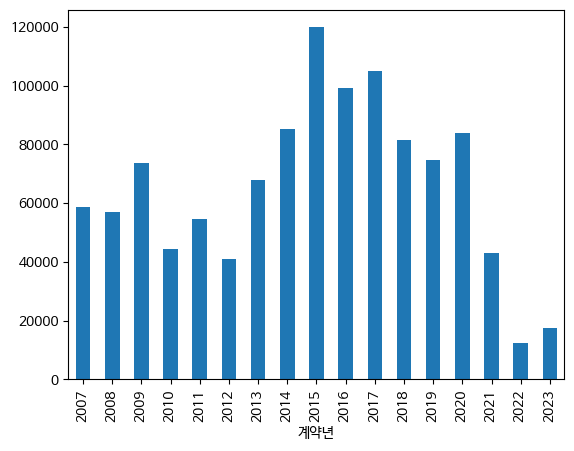

In [6]:
# 연도별 거래량
print(a['target'])
a['target'].plot(kind='bar')

##### 각 연도의 시군구별 거래량

In [336]:
dt_year_month[dt_year_month['계약년'] == 2015].groupby('시군구').count()

번지    본번    부번  아파트명  전용면적(㎡)  계약년월   계약일     층  건축년도   도로명  \
시군구                                                                            
서울특별시 강남구 개포동  1530  1530  1530  1530     1530  1530  1530  1530  1530  1530   
서울특별시 강남구 논현동   323   323   323   323      323   323   323   323   323   323   
서울특별시 강남구 대치동   939   939   939   939      939   939   939   939   939   939   
서울특별시 강남구 도곡동   992   992   992   992      992   992   992   992   992   992   
서울특별시 강남구 삼성동   706   706   706   706      706   706   706   706   706   706   
...             ...   ...   ...   ...      ...   ...   ...   ...   ...   ...   
서울특별시 중랑구 면목동   904   904   904   904      904   904   904   904   904   904   
서울특별시 중랑구 묵동    653   653   653   653      653   653   653   653   653   653   
서울특별시 중랑구 상봉동   512   512   512   512      512   512   512   512   512   512   
서울특별시 중랑구 신내동  1295  1295  1295  1295     1295  1295  1295  1295  1295  1295   
서울특별시 중랑구 중화동   298   298   298   298      298   298   298   298   298   298   

               ...  기타/의무/임대/임의=1/2/3/4  단지승인일  사용허가여부  관리비 업로드  좌표X  좌표Y  \
시군구            ...                                                          
서울특별시 강남구 개포동  ...                  523    523     523      523  523  523   
서울특별시 강남구 논현동  ...                   49     49      49       49   49   49   
서울특별시 강남구 대치동  ...                  489    489     489      489  489  489   
서울특별시 강남구 도곡동  ...                  272    272     272      272  272  272   
서울특별시 강남구 삼성동  ...                   14     14      14       14   13   13   
...            ...                  ...    ...     ...      ...  ...  ...   
서울특별시 중랑구 면목동  ...                  128    128     128      128  128  128   
서울특별시 중랑구 묵동   ...                   28     28      28       28   28   28   
서울특별시 중랑구 상봉동  ...                   82     82      82       82   82   82   
서울특별시 중랑구 신내동  ...                   13     13      13       13   13   13   
서울특별시 중랑구 중화동  ...                    0      0       0        0    0    0   

               단지신청일  target   계약년   계약월  
시군구                                       
서울특별시 강남구 개포동    523    1530  1530  1530  
서울특별시 강남구 논현동     49     323   323   323  
서울특별시 강남구 대치동    489     939   939   939  
서울특별시 강남구 도곡동    272     992   992   992  
서울특별시 강남구 삼성동     14     706   706   706  
...              ...     ...   ...   ...  
서울특별시 중랑구 면목동    128     904   904   904  
서울특별시 중랑구 묵동      28     653   653   653  
서울특별시 중랑구 상봉동     82     512   512   512  
서울특별시 중랑구 신내동     13    1295  1295  1295  
서울특별시 중랑구 중화동      0     298   298   298  

[312 rows x 53 columns]

In [9]:
a = dt_year_month.groupby(['계약년','시군구']).count()

In [16]:
dt_year_month.groupby(['계약년','시군구']).count()

번지     본번     부번   아파트명  전용면적(㎡)   계약년월    계약일      층  \
계약년  시군구                                                                       
2007 서울특별시 강남구 개포동  False  False  False  False    False  False  False  False   
     서울특별시 강남구 논현동  False  False  False  False    False  False  False  False   
     서울특별시 강남구 대치동  False  False  False  False    False  False  False  False   
     서울특별시 강남구 도곡동  False  False  False  False    False  False  False  False   
     서울특별시 강남구 삼성동  False  False  False  False    False  False  False  False   
...                   ...    ...    ...    ...      ...    ...    ...    ...   
2023 서울특별시 중랑구 면목동  False  False  False  False    False  False  False  False   
     서울특별시 중랑구 묵동   False  False  False  False    False  False  False  False   
     서울특별시 중랑구 상봉동  False  False  False  False    False  False  False  False   
     서울특별시 중랑구 신내동  False  False  False  False    False  False  False  False   
     서울특별시 중랑구 중화동  False  False  False  False    False  False  False  False   

                     건축년도    도로명  ...   주차대수  기타/의무/임대/임의=1/2/3/4  단지승인일  \
계약년  시군구                          ...                                      
2007 서울특별시 강남구 개포동  False  False  ...  False                False  False   
     서울특별시 강남구 논현동  False  False  ...  False                False  False   
     서울특별시 강남구 대치동  False  False  ...  False                False  False   
     서울특별시 강남구 도곡동  False  False  ...  False                False  False   
     서울특별시 강남구 삼성동  False  False  ...  False                False  False   
...                   ...    ...  ...    ...                  ...    ...   
2023 서울특별시 중랑구 면목동  False  False  ...  False                False  False   
     서울특별시 중랑구 묵동   False  False  ...  False                False  False   
     서울특별시 중랑구 상봉동  False  False  ...  False                False  False   
     서울특별시 중랑구 신내동  False  False  ...  False                False  False   
     서울특별시 중랑구 중화동  False  False  ...  False                False  False   

                    사용허가여부  관리비 업로드    좌표X    좌표Y  단지신청일  target    계약월  
계약년  시군구                                                                 
2007 서울특별시 강남구 개포동   False    False  False  False  False   False  False  
     서울특별시 강남구 논현동   False    False  False  False  False   False  False  
     서울특별시 강남구 대치동   False    False  False  False  False   False  False  
     서울특별시 강남구 도곡동   False    False  False  False  False   False  False  
     서울특별시 강남구 삼성동   False    False  False  False  False   False  False  
...                    ...      ...    ...    ...    ...     ...    ...  
2023 서울특별시 중랑구 면목동   False    False  False  False  False   False  False  
     서울특별시 중랑구 묵동    False    False  False  False  False   False  False  
     서울특별시 중랑구 상봉동   False    False  False  False  False   False  False  
     서울특별시 중랑구 신내동   False    False  False  False  False   False  False  
     서울특별시 중랑구 중화동   False    False  False  False  False   False  False  

[5176 rows x 52 columns]

<Axes: xlabel='시군구'>

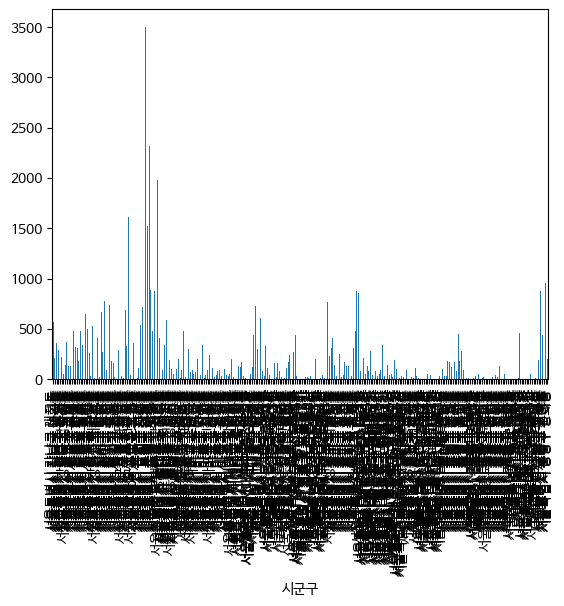

In [18]:
dt_year_month[dt_year_month['계약년'] == 2007].groupby(['시군구']).count()['target'].plot(kind='bar')

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

<Axes: xlabel='시군구'>

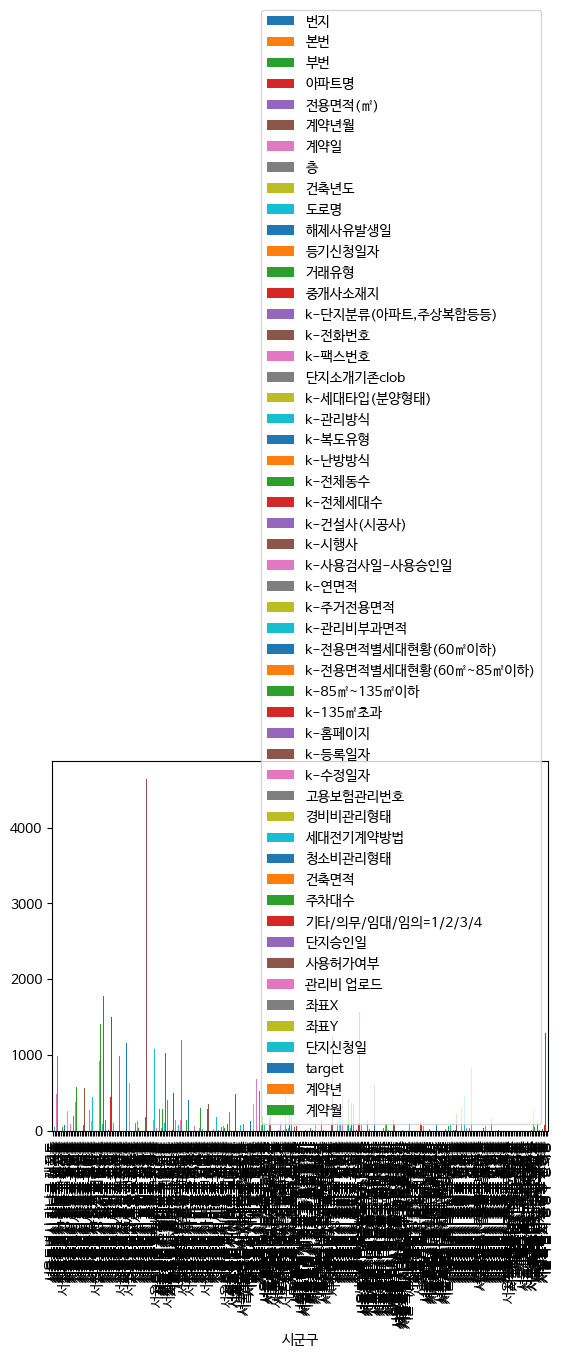

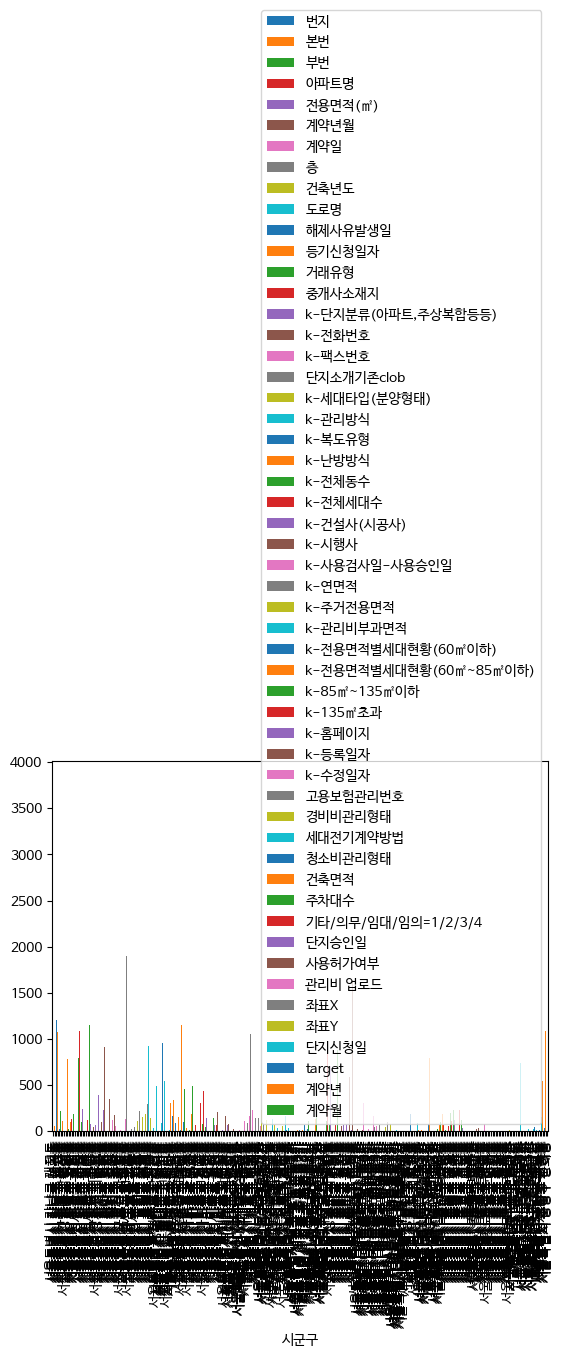

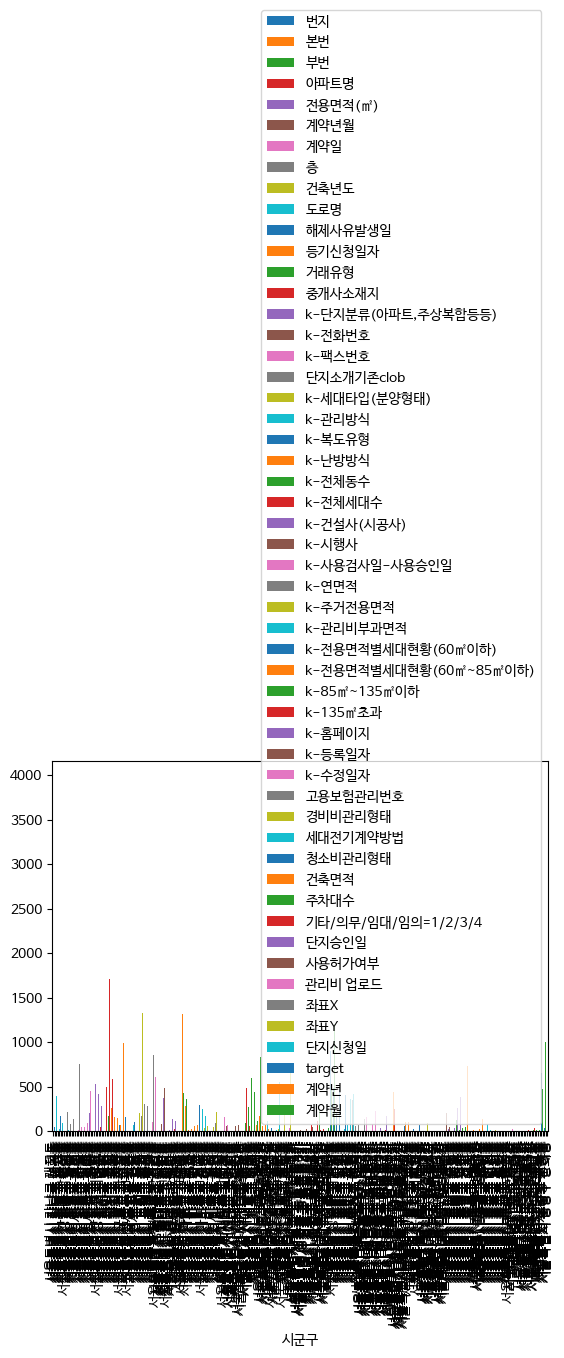

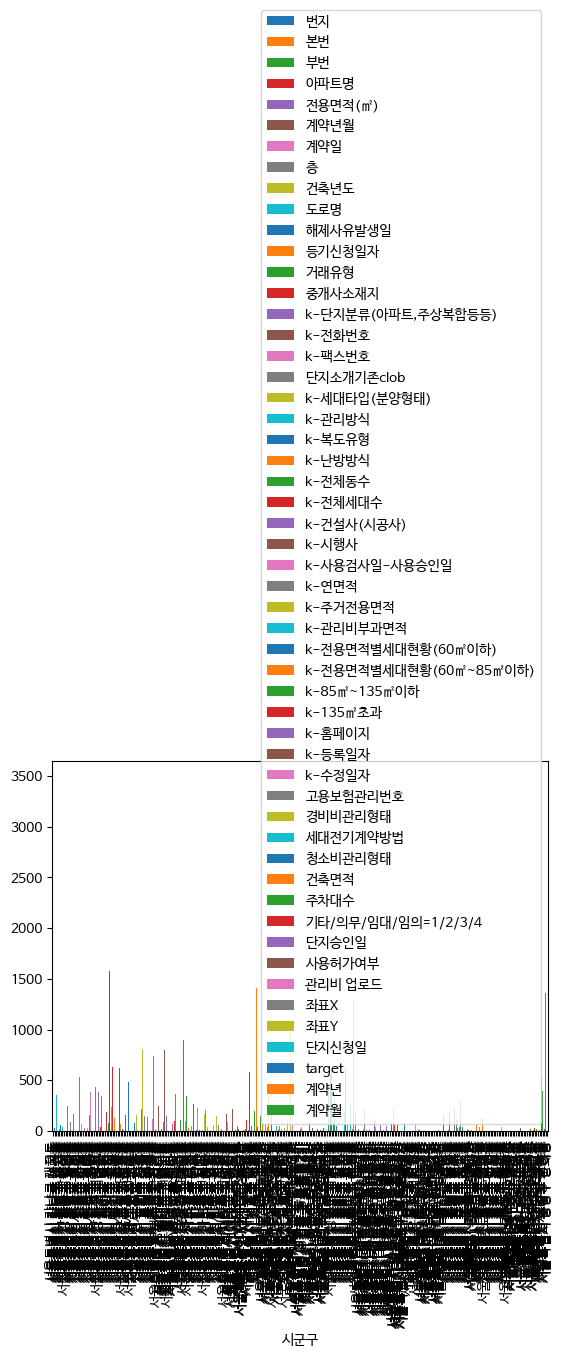

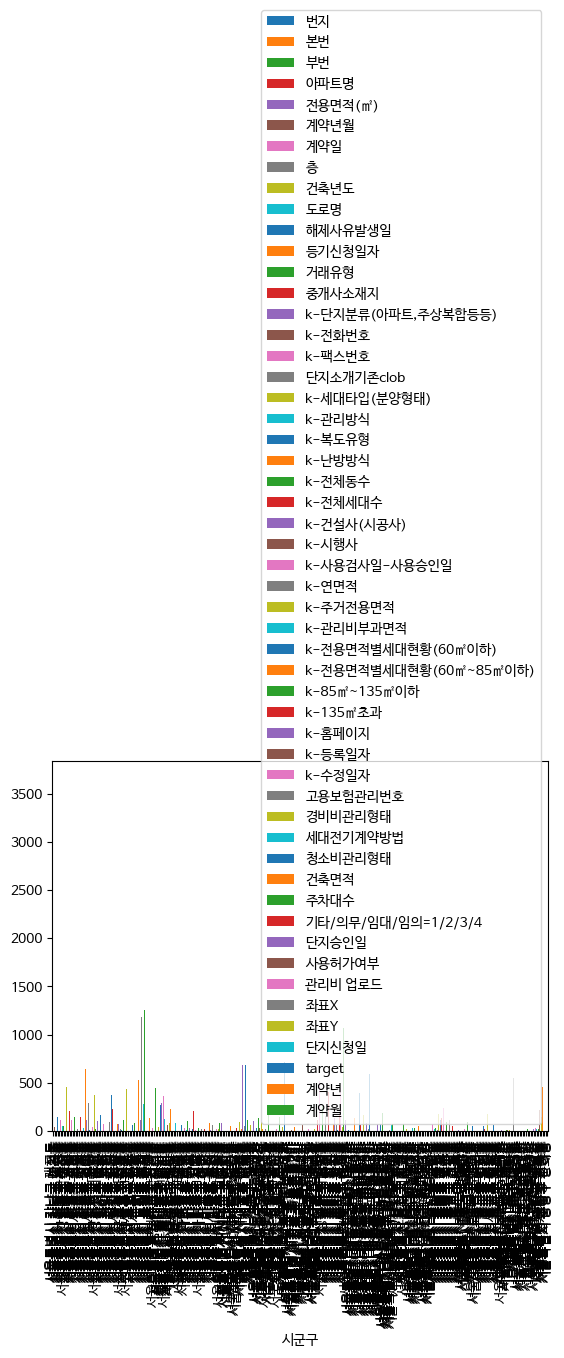

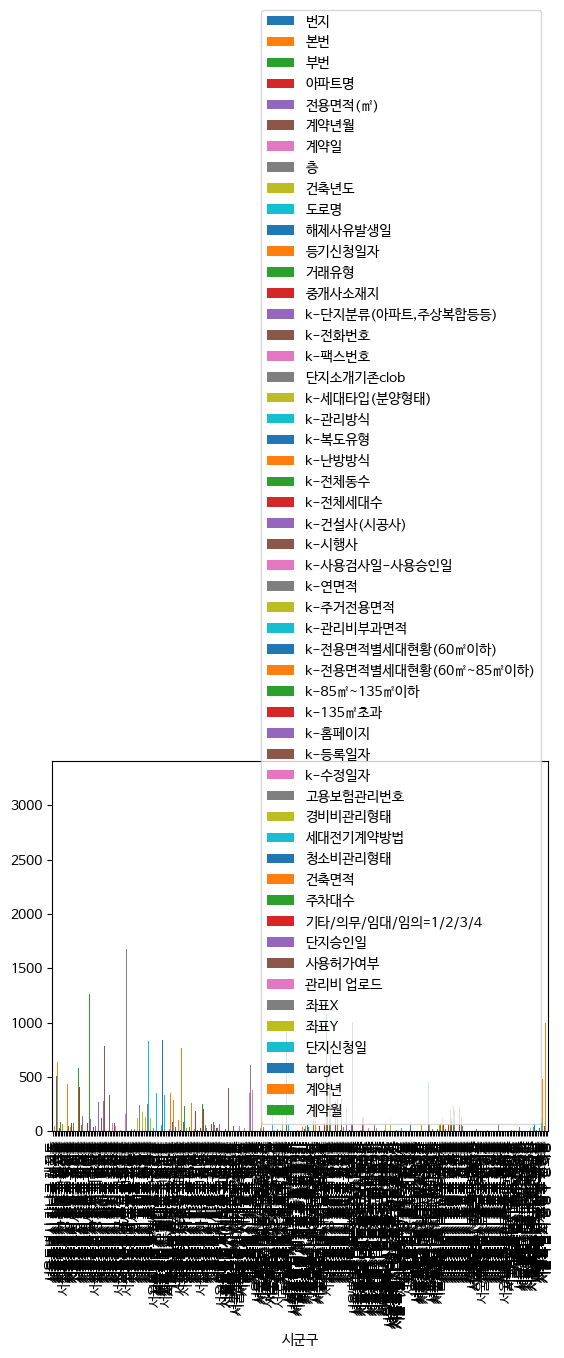

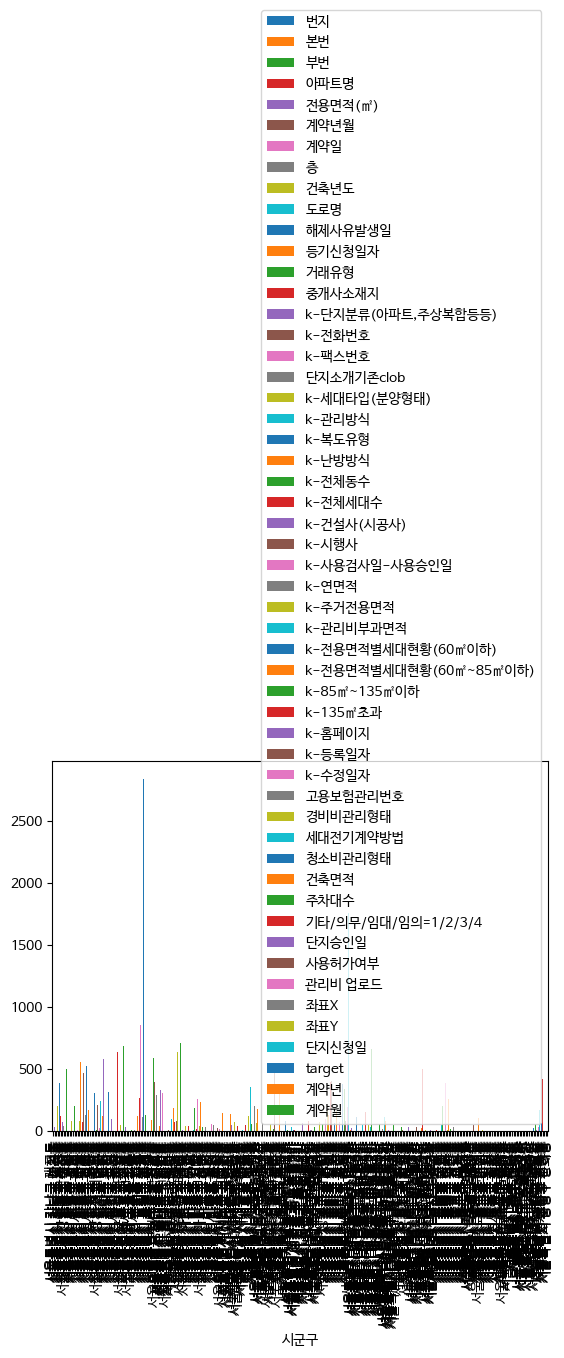

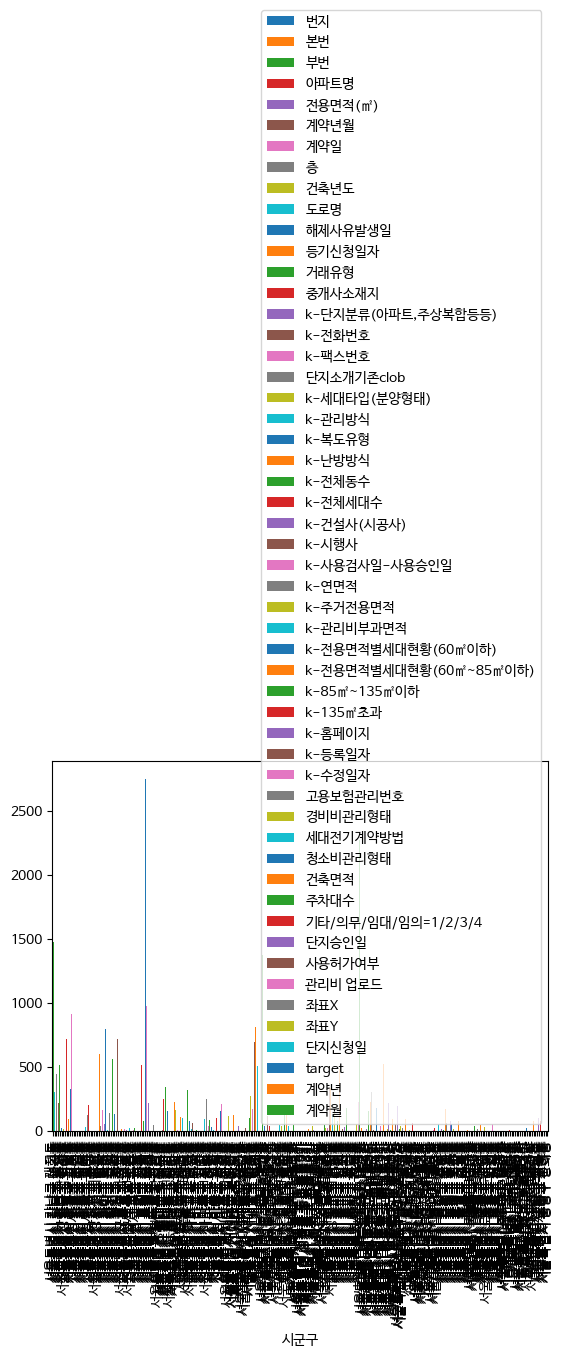

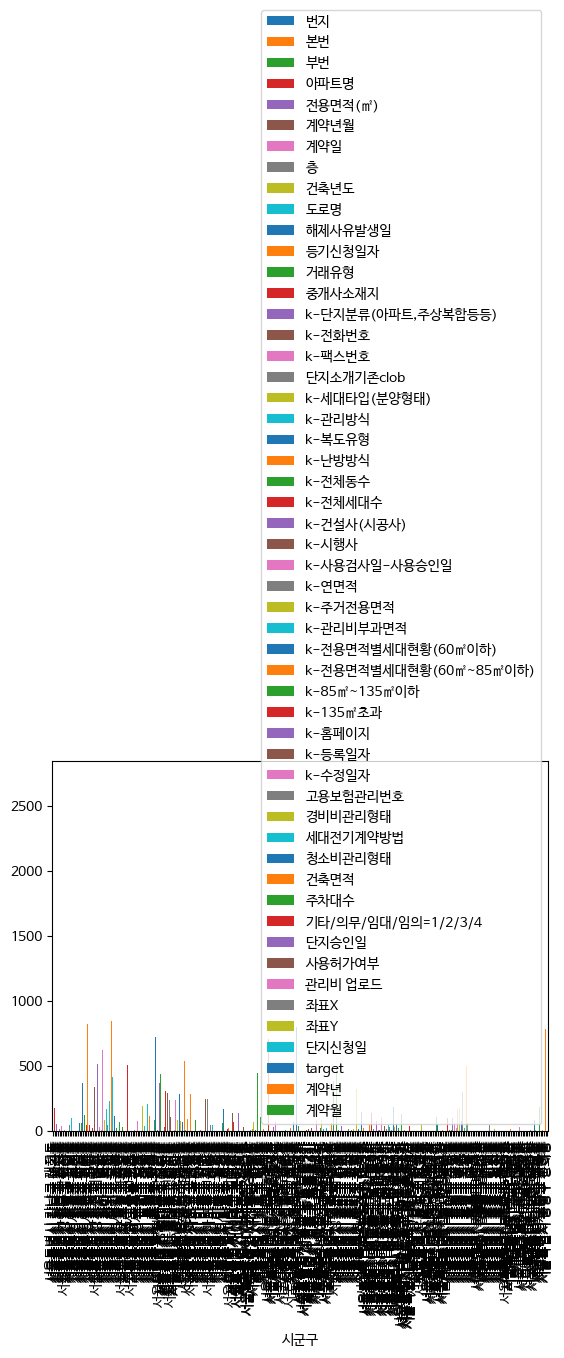

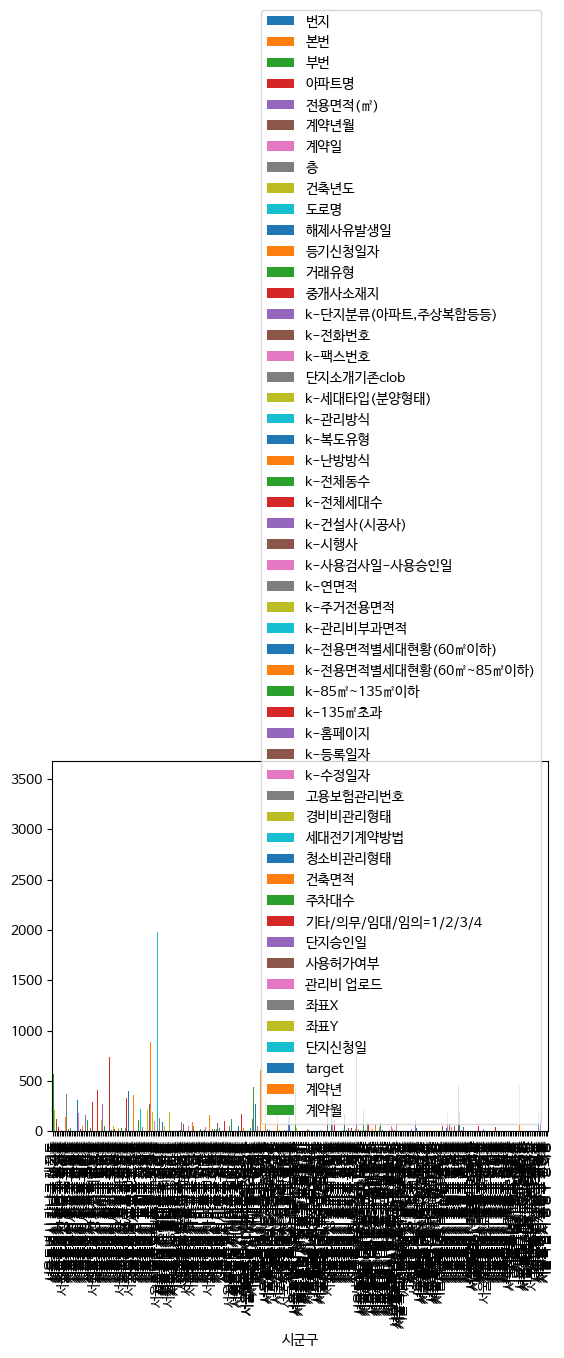

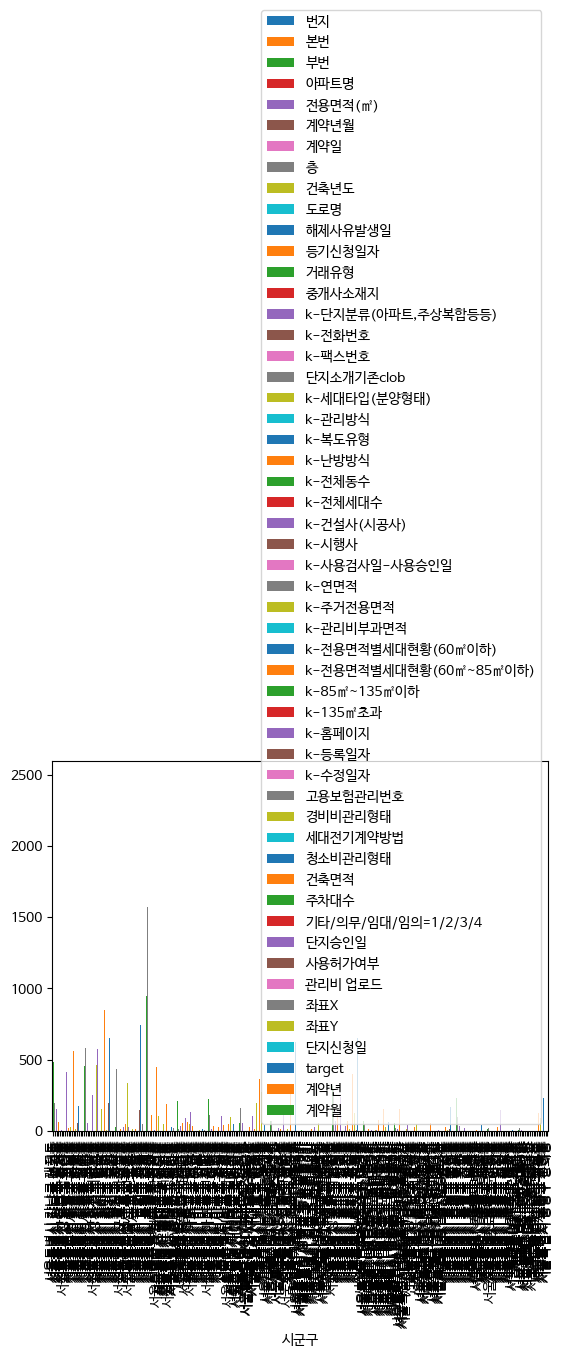

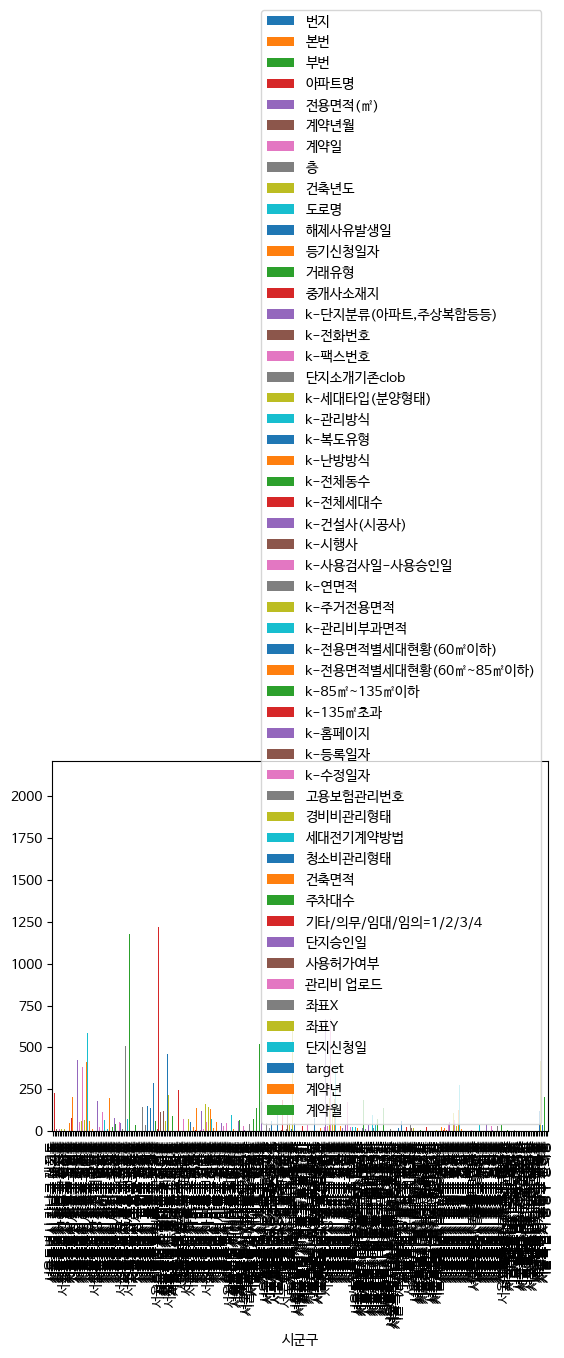

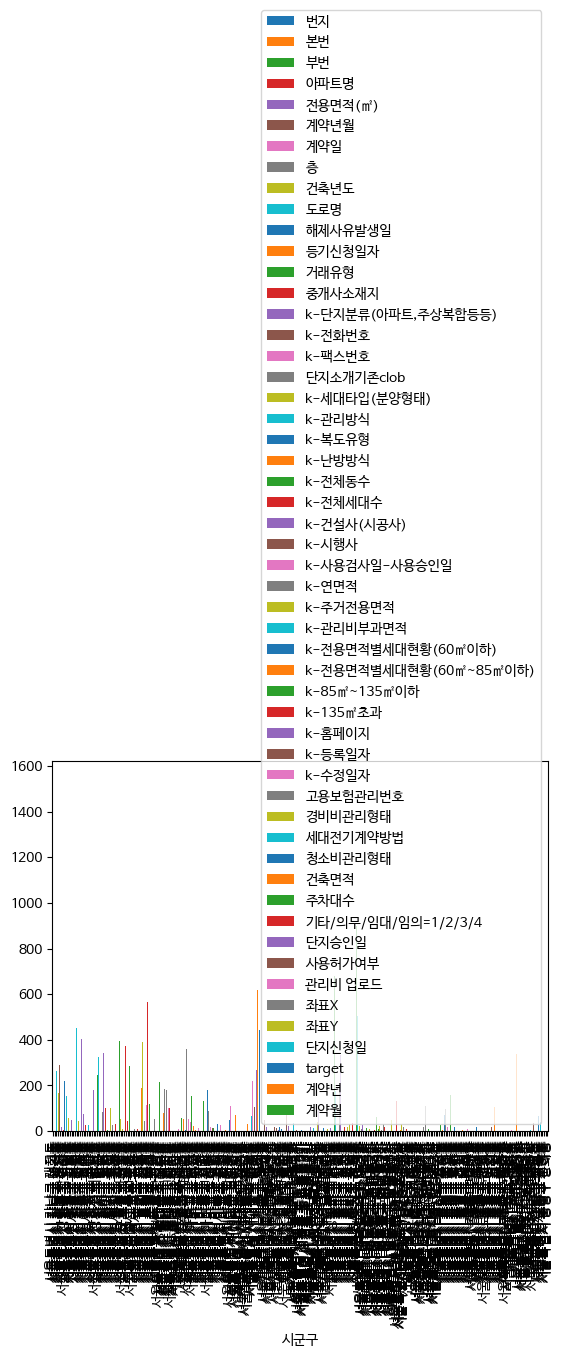

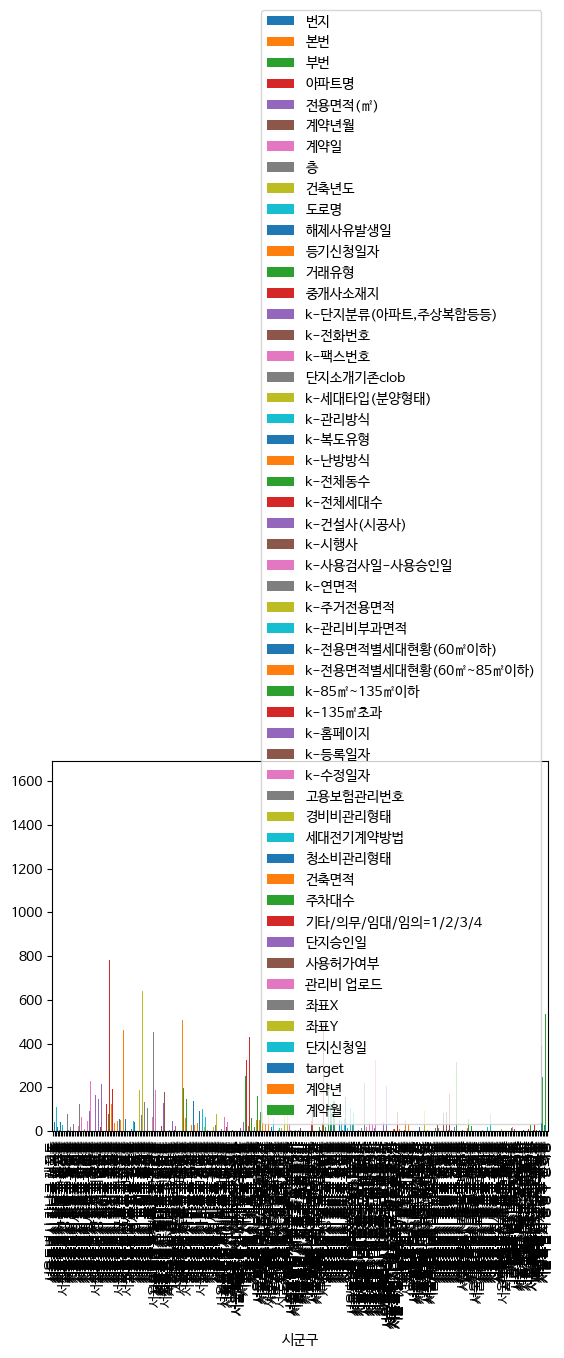

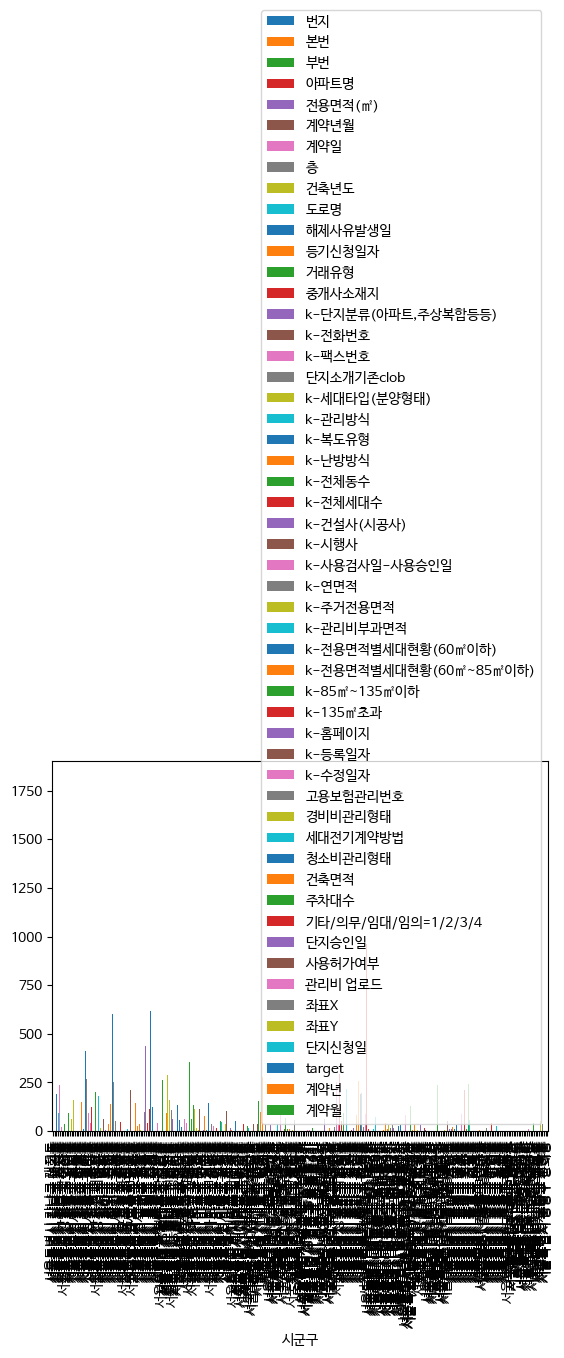

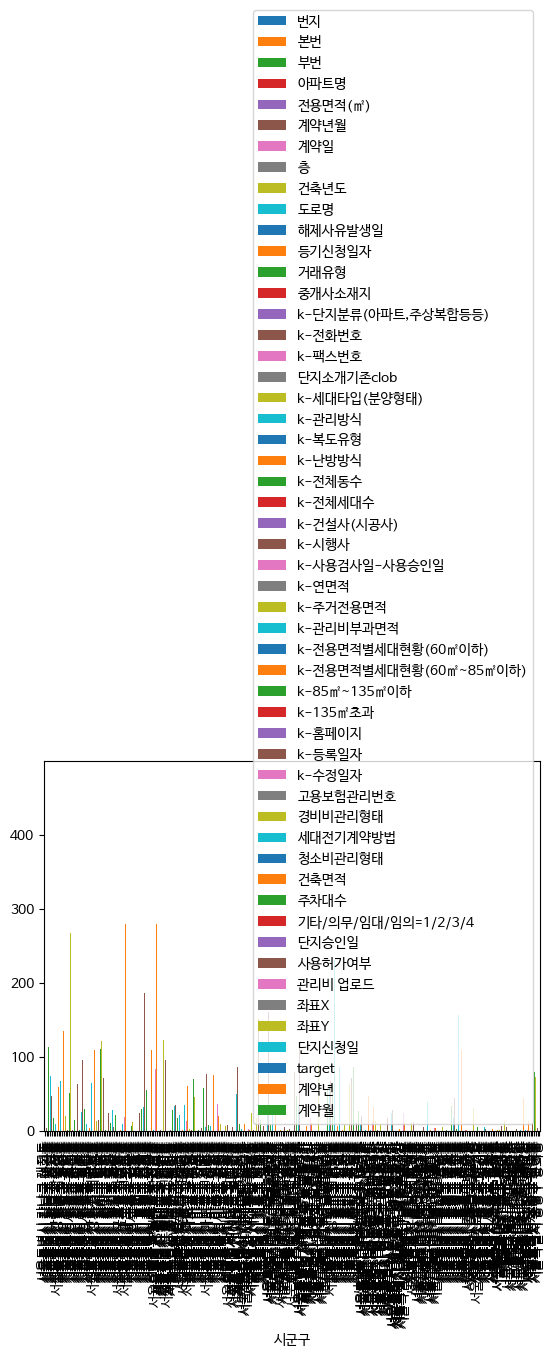

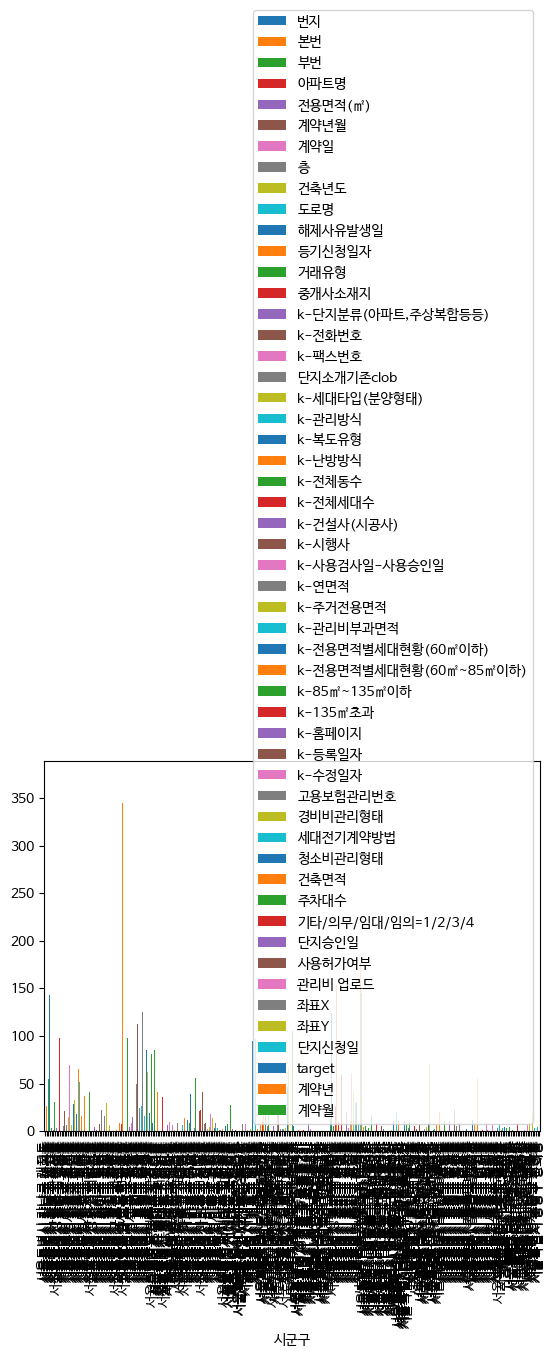

In [20]:
for i in dt_year_month['계약년'].value_counts().index:
    display(dt_year_month[dt_year_month['계약년'] == i].groupby('시군구').count().plot(kind='bar'))
    # construction_year_distribution = pd.DataFrame(dt['건축년도'].value_counts().sort_index())
    # fig = plt.figure(figsize=(16, 5))
    # sns.barplot(data = construction_year_distribution, x=construction_year_distribution.index, y='건축년도')
    # plt.xticks(rotation = 45)
    # plt.show()